# Install package

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)




/bin/bash: nvidia-smi: command not found


In [ ]:
!pip install tensorflow==2.13.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 22.6 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: gast
    Found existing installation: gast 0.6.0
    Uninstalling gast-0.6.0:
      

In [ ]:
!pip install mat4py
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# A RNN-based Reinforcement Learning Framework for Frequency Control Problem with Stability Guarantee
import collections
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import gym
import tensorflow as tf
# import tensorflow_probability as tfp

import os
import random
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.layers import RNN
import tensorflow.keras.backend as K
import sys
from gym import spaces
from gym.utils import seeding
import copy
from mat4py import loadmat
from tensorflow.keras import layers
from tensorflow import keras
import networkx as nx
import scipy
import pickle
import time


In [ ]:
import random
from datetime import datetime
random.seed(datetime.now())

<ipython-input-4-ffa94a10b395>:3: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(datetime.now())


# Environment Setup

In [ ]:
# Frequency Control Porblem Environment
class Frequency(gym.Env):
    def  __init__(self, Pm,M,D,F,delta_t,max_action,dim_action,Penalty_action, coef_cost):
        self.param_gamma = 1
        self.sigma_e=0.05
        self.M = M
        self.D = D
        self.Pm = Pm
        self.max_action = max_action
        self.dim_action = dim_action
        self.omega_scale = 2*np.pi# this change the unit of omega to Hz
        self.viewer  =  None
        self.state_x = []
        self.delta_t = delta_t
        self.Penalty_action = Penalty_action
        self.state_x_transfer1 = np.vstack((np.hstack((np.identity(dim_action,dtype = np.float32),np.zeros((dim_action,dim_action),dtype = np.float32))),\
                                np.hstack((delta_t*self.omega_scale*np.identity(dim_action,dtype = np.float32),\
                                           np.identity(dim_action,dtype = np.float32)-delta_t*np.diag(D/M)))))

        self.state_x_transferF = -delta_t*(((M**(-1)).reshape(dim_action,1))@np.ones((1,dim_action),dtype = np.float32))*F
        self.state_x_transfer2 = np.hstack((np.zeros((dim_action,dim_action),dtype = np.float32),\
                                        np.identity(dim_action,dtype = np.float32)))

        self.state_x_transfer3 = np.hstack((np.zeros((1,dim_action),dtype = np.float32),\
                                        delta_t*Pm*(M**(-1))))
        self.state_x_transfer3_Pm = np.hstack((np.zeros((dim_action,dim_action),dtype = np.float32),\
                                        delta_t*np.diag((M**(-1)))))
        self.state_x_transfer4 = np.hstack((np.zeros((dim_action,dim_action),dtype = np.float32),\
                                        -delta_t*np.diag((M**(-1)))))

        self.select_add_w = np.vstack((np.zeros((dim_action,1),dtype = np.float32),\
                                        np.ones((dim_action,1),dtype = np.float32)))
        self.select_w = np.vstack((np.zeros((dim_action,dim_action),dtype = np.float32),\
                                        np.identity(dim_action,dtype = np.float32)))
        self.select_delta = np.vstack((np.identity(dim_action,dtype = np.float32),\
                                        np.zeros((dim_action,dim_action),dtype = np.float32)))
        self.diag_c  =  np.diag(coef_cost)

        # np.identity(dim_action,dtype = np.float32)


    def step(self, action,Pm):

        cost_action, grad_action  =  self.calc_grad_action(action)
        dot_s_new  =  self.state_x@self.select_w-\
                np.sum(np.transpose(grad_action)@np.ones((1,dim_action),dtype = np.float32)\
                - np.ones((dim_action,1),dtype = np.float32)@grad_action,axis = 1)@self.diag_c*0.05
        self.state_x  =  copy.deepcopy(self.state_x@self.state_x_transfer1\
              + np.sum(np.sin( np.transpose(self.state_x@self.select_delta)@np.ones((1,dim_action),dtype = np.float32)-\
                np.ones((dim_action,1),dtype = np.float32)@(self.state_x@self.select_delta))*self.state_x_transferF,axis = 1 )\
                      @self.state_x_transfer2\
              + Pm@self.state_x_transfer3_Pm\
                          +action@self.state_x_transfer4)
        self.state_s  =  self.state_s+self.delta_t*dot_s_new/1
        loss  =  self.param_gamma*pow(self.state_x,2)@self.select_add_w
        return self.state_s, self.state_x, loss



    def step_PI_CommEdge_WoCost(self, actionP, actionI,Pm):

        action  =  actionP + actionI
        dot_s_new  =  self.state_x@self.select_w
        self.state_x  =  copy.deepcopy(self.state_x@self.state_x_transfer1\
              + np.sum(np.sin( np.transpose(self.state_x@self.select_delta)@np.ones((1,dim_action),dtype = np.float32)-\
                np.ones((dim_action,1),dtype = np.float32)@(self.state_x@self.select_delta))*self.state_x_transferF,axis = 1 )\
                      @self.state_x_transfer2\
              + Pm@self.state_x_transfer3_Pm\
                          +action@self.state_x_transfer4)
        self.state_s  =  self.state_s+self.delta_t*dot_s_new/1
        loss  =  self.param_gamma*pow(self.state_x,2)@self.select_add_w
        return self.state_s, self.state_x, loss


    def set_state(self, state_input):
        self.state_x = state_input
        self.state_s  =  np.zeros((1,dim_action),dtype = np.float32)

    def calc_grad_action(self, action):
        return 0.5*(action**4)@self.diag_c, 2*(action**3)@self.diag_c

    def reset(self):
        initial_state1 = np.random.uniform(0.0,0.3,(1,self.dim_action))
        initial_state2 = np.random.uniform(-0.03,0.03,(1,self.dim_action))
        s_concate = np.hstack((initial_state1,initial_state2)).astype(np.float32)
        self.state_x  =  s_concate
        self.state_s  =  np.zeros((1,dim_action),dtype = np.float32)

        return self.state_x




In [ ]:
# Simulation data load from IEEE 39-bus system
data = loadmat('/content/drive/MyDrive/Colab Notebooks/IEEE_39bus_Kron_new.mat')

K_EN=data['Kron_39bus']['K']
K_EN=np.asarray(K_EN, dtype=np.float32)

H=data['Kron_39bus']['H']
H=np.asarray(H, dtype=np.float32)

Damp=data['Kron_39bus']['D']
Damp=np.asarray(Damp, dtype=np.float32)

omega_R=data['Kron_39bus']['omega_R']

A_EN=data['Kron_39bus']['A']
A_EN=np.asarray(A_EN, dtype=np.float32)

gamma=data['Kron_39bus']['gamma']
gamma=np.asarray(gamma, dtype=np.float32)

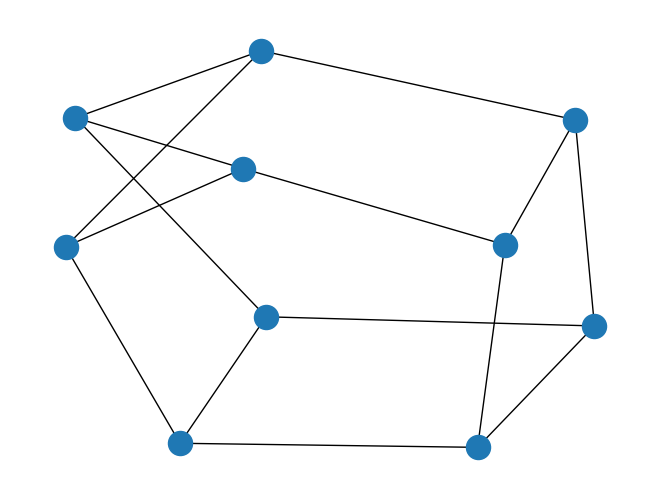

In [ ]:

# G_comm = nx.random_regular_graph(3, dim_action, seed=4)
# incidence_comm = scipy.sparse.csr_matrix.toarray(nx.incidence_matrix(G_comm, oriented=True))

f = open('/content/drive/MyDrive/Colab Notebooks/4. EIP Neurips/Power System/data/Comm.pckl', 'rb')
[G_comm,  incidence_comm]= pickle.load(f)
f.close()
nx.draw(G_comm)


In [ ]:

delta_t=0.005
M=H.reshape(dim_action)*2/omega_R*2*np.pi
D=np.zeros(dim_action,dtype=np.float32)
# Here use the D data from P. Demetriou, M. Asprou, J. Quiros-Tortos, and E. Kyriakides, “Dynamic ieee test systems for transient analysis,”

D[0]=2*590/100
D[1:8]=2*865/100
D[8:10]=2*911/100;
D=D/omega_R*2*np.pi
linear_coff=np.array([20.14369  , 28.201817 , 21.431381 , 50.06875  , 47.848213 ,
        40.610752 , 36.394817 , 15.173219 , 55.339428 , 13.4945965], dtype=np.float32)*0.01
D = D+linear_coff
F=K_EN
Penalty_action=0.01*0.2
Pm=np.array([[-0.19983394, -0.25653884, -0.25191885, -0.10242008, -0.34510365,
         0.23206371,  0.4404325 ,  0.5896664 ,  0.26257738, -0.36892462]],dtype=np.float32)

max_action=np.array([[0.19606592, 0.2190382 , 0.22375287, 0.0975513 , 0.29071101,
        0.22091283, 0.38759459, 0.56512538, 0.24151538, 0.29821917]],dtype=np.float32)*5
equilibrium_init=np.array([[ -0.05420687, -0.07780334, -0.07351729, -0.05827823, -0.09359571,
        -0.02447385, -0.00783582,  0.00259523, -0.0162409 , -0.06477749,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.       ]],dtype=np.float32)
coef_cost = np.array([0.94162537, 1.15464676, 0.55487802, 0.71176656, 1.27476119,
       1.02529959, 1.2946042 , 1.01800112, 0.99465694, 0.73467357], dtype=np.float32)
# np.random.uniform(0.5,1.5,(dim_action))
env = Frequency(Pm,M,D,F,delta_t,max_action,dim_action,Penalty_action, coef_cost, incidence_comm)
max_action

array([[0.9803296, 1.095191 , 1.1187644, 0.4877565, 1.4535551, 1.1045642,
        1.9379729, 2.825627 , 1.2075769, 1.4910959]], dtype=float32)

# Train

### Neural-PI

In [ ]:
# RNN Cell to integrate state transition dynamics
class MinimalRNNCell_WoCost_SCNN(keras.layers.Layer):

    def __init__(self, units, action_units_node_p, action_units_node_i, internal_units,internal_units_SCNN, env,batchsize,**kwargs):
        self.units = units
        self.state_size = units
        self.action_units_node_p = action_units
        self.action_units_node_i = action_units
        self.internal_units = internal_units
        self.internal_units_SCNN = internal_units_SCNN
        self.batchsize = batchsize
        self.delta_t = tf.constant(env.delta_t,dtype = tf.float32)

        self.state_x_transfer1 = tf.constant(env.state_x_transfer1,dtype = tf.float32)
        self.state_x_transferF = tf.constant(env.state_x_transferF,dtype = tf.float32)
        self.state_x_transfer2 = tf.constant(env.state_x_transfer2,dtype = tf.float32)
        self.state_x_transfer3 = tf.constant(env.state_x_transfer3,dtype = tf.float32)
        self.state_x_transfer4 = tf.constant(env.state_x_transfer4,dtype = tf.float32)
        self.state_x_transfer3_Pm = tf.constant(env.state_x_transfer3_Pm,dtype = tf.float32)
        self.select_add_w = tf.constant(env.select_add_w,dtype = tf.float32)
        self.select_w = tf.constant(env.select_w,dtype = tf.float32)
        self.select_delta = tf.constant(env.select_delta,dtype = tf.float32)
        self.max_action = tf.constant(env.max_action,dtype = tf.float32)
        self.w_recover = tf.constant(tf.linalg.band_part(-tf.ones((internal_units,internal_units)),0,1)\
                                        +2*tf.eye(internal_units),dtype = tf.float32)
        self.b_recover = tf.constant(tf.linalg.band_part(tf.ones((internal_units,internal_units)),0,-1)\
                                        -tf.eye(internal_units),dtype = tf.float32)
        self.diag_c = tf.constant(env.diag_c, dtype = tf.float32)
############ PI controller :P

        self.Multiply_ones_node_p = tf.tile(tf.ones((action_units_node_p,action_units_node_p),dtype=np.float32)[None], [batchsize, 1, 1])
        self.ones_node_p = tf.ones((action_units_node_p,internal_units),dtype=tf.float32)

############ PI controller :I
        self.Multiply_ones_node_i = tf.tile(tf.ones((action_units_node_i,action_units_node_i),dtype=np.float32)[None], [batchsize, 1, 1])
        self.ones_node_i = tf.ones((action_units_node_i,internal_units),dtype=tf.float32)
        self.obs_zeros = tf.zeros((1, action_units_node_p))


        super(MinimalRNNCell_WoCost_SCNN, self).__init__(**kwargs)

    def build(self, input_shape):
############# PI controller  : P
        self.W_p1 =  self.add_weight(
            shape=(self.action_units_node_p,self.internal_units_SCNN),
            initializer='random_normal',
            trainable=True,
            name='W_p1')
        self.b_p1 =  self.add_weight(
            shape=(self.internal_units_SCNN,),
            initializer='random_normal',
            trainable=True,
            name='b_p1')
        self.W_p2 =  self.add_weight(
            shape=(self.action_units_node_p,self.internal_units_SCNN),
            initializer='random_normal',
            trainable=True,
            name='W_p2')
        self.W_pz1 =  self.add_weight(
            shape=(self.internal_units_SCNN,self.internal_units_SCNN),
            initializer='random_normal',
            trainable=True,
            constraint = tf.keras.constraints.non_neg(),
            name='W_pz1')
        self.b_p2 =  self.add_weight(
            shape=(self.internal_units_SCNN,),
            initializer='random_normal',
            trainable=True,
            name='b_p2')

        self.W_p3 =  self.add_weight(
            shape=(self.action_units_node_p,1),
            initializer='random_normal',
            trainable=True,
            name='W_p3')
        self.W_pz2 =  self.add_weight(
            shape=(self.internal_units_SCNN,1),
            initializer='uniform',
            trainable=True,
            constraint = tf.keras.constraints.non_neg(),
            name='W_pz2')
        self.b_p3 =  self.add_weight(
            shape=(1,),
            initializer='random_normal',
            trainable=True,
            name='b_p3')

        ######################### integral
        self.W_i1 =  self.add_weight(
            shape=(self.action_units_node_p,self.internal_units_SCNN),
            initializer='random_normal',
            trainable=True,
            name='W_i1')
        self.b_i1 =  self.add_weight(
            shape=(self.internal_units_SCNN,),
            initializer='random_normal',
            trainable=True,
            name='b_i1')
        self.W_i2 =  self.add_weight(
            shape=(self.action_units_node_p,self.internal_units_SCNN),
            initializer='random_normal',
            trainable=True,
            name='W_i2')
        self.W_iz1 =  self.add_weight(
            shape=(self.internal_units_SCNN,self.internal_units_SCNN),
            initializer='uniform',
            trainable=True,
            constraint = tf.keras.constraints.non_neg(),
            name='W_iz1')
        self.b_i2 =  self.add_weight(
            shape=(self.internal_units_SCNN,),
            initializer='random_normal',
            trainable=True,
            name='b_i2')

        self.W_i3 =  self.add_weight(
            shape=(self.action_units_node_p,1),
            initializer='random_normal',
            trainable=True,
            name='W_i3')
        self.W_iz2 =  self.add_weight(
            shape=(self.internal_units_SCNN,1),
            initializer='uniform',
            trainable=True,
            constraint = tf.keras.constraints.non_neg(),
            name='W_iz2')
        self.b_i3 =  self.add_weight(
            shape=(1,),
            initializer='random_normal',
            trainable=True,
            name='b_i3')


        self.w_beta =  self.add_weight(
            # shape=(1),
            initializer=tf.constant_initializer(1),
            trainable=True,
            name='beta')

        self.built = True

    @tf.function
    def SCNN_action(self, obs):

        with tf.GradientTape() as tape:
            tape.watch(obs)
            z1 = self.softplus_beta(K.dot(obs, self.W_p1)+ self.b_p1)
            z2 = self.softplus_beta(K.dot(obs, self.W_p2)+K.dot(z1, self.W_pz1)+ self.b_p2)
            z3 = self.softplus_beta(K.dot(obs, self.W_p3)+K.dot(z2, self.W_pz2)+ self.b_p3)
        action_node_p = tf.squeeze(tape.batch_jacobian(z3, obs))
        return action_node_p

    @tf.function
    def SCNN_actionI(self, obs):

        with tf.GradientTape() as tape:
            tape.watch(obs)
            z1 = self.softplus_beta(K.dot(obs, self.W_i1)+ self.b_i1)
            z2 = self.softplus_beta(K.dot(obs, self.W_i2)+K.dot(z1, self.W_iz1)+ self.b_i2)
            z3 = self.softplus_beta(K.dot(obs, self.W_i3)+K.dot(z2, self.W_iz2)+ self.b_i3)
        action_node_i = 1*tf.squeeze(tape.batch_jacobian(z3, obs))

        return action_node_i

    @tf.function
    def softplus_beta(self, x):

        return K.softplus(self.w_beta*x)/(self.w_beta)

    @tf.function
    def call(self, inputs, states):
        # stacked ReLU structure to represent control network
        prev_state = states[0]
        prev_state_x = prev_state[:,0:self.action_units_node_p*2]
        prev_state_s =  prev_state[:,self.action_units_node_p*2:self.action_units_node_p*3]
##################### PI: P

        obs_y = K.dot(prev_state_x,self.select_w)
        action_node_p = self.SCNN_action(obs_y)-self.SCNN_action(self.obs_zeros)


##################### PI: I

        action_node_i = self.SCNN_actionI(prev_state_s)-self.SCNN_actionI(self.obs_zeros)


###########################
        action_nonconstrain = action_node_p + action_node_i
        action =  self.max_action-K.relu(self.max_action-action_nonconstrain)+K.relu(-self.max_action-action_nonconstrain)
        #
#########################
        # calculate state on s
        dot_s = K.dot(prev_state_x,self.select_w)

#######################
        # integrate the state transition dynamics
        new_state_x = K.dot(prev_state_x, self.state_x_transfer1)+\
            K.dot(K.sum(K.sin( K.dot(tf.linalg.diag(K.dot(prev_state_x, self.select_delta)),tf.ones((dim_action,dim_action),dtype = np.float32))-\
                                tf.matmul(self.Multiply_ones_node_p,tf.linalg.diag(K.dot(prev_state_x, self.select_delta))))\
                        *self.state_x_transferF,axis = 2 )\
                                      ,self.state_x_transfer2)\
                             + self.state_x_transfer3+K.dot(action,self.state_x_transfer4)\
                             + inputs@self.state_x_transfer3_Pm


        loss0 = K.dot(K.pow(new_state_x,2),self.select_add_w)
        frequency = K.dot(new_state_x,self.select_w)
        new_state_s = prev_state_s + self.delta_t*dot_s
        next_state = tf.concat([new_state_x,  new_state_s], axis = 1)
        return [loss0,frequency,action_node_p,action_node_i, action], [next_state]




In [ ]:
loop_seed = 1
model_list = []
loss_list = []
episodes  = 400 # total number of iterations to update weights
units = dim_action*3 #dimension of each state
internal_units = 20 # demension of the neural network for control policy
internal_units_SCNN = 20
T = 400  #Total period considered
Batch_num = 300 # number of batch in each episodes
PrintUpdate = 1
Comp_time_list = []

for loop in range(0,loop_seed):
    random.seed(datetime.now())

    start = time.time()

    cell_WoCost_SCNN = MinimalRNNCell_WoCost_SCNN(units,dim_action, dim_action, internal_units, internal_units_SCNN, env,Batch_num)
    layer_WoCost_SCNN = RNN(cell_WoCost_SCNN,return_sequences = True,stateful = True)
    input_1 = tf.keras.Input(batch_shape = (Batch_num,T,dim_action))
    outputs = layer_WoCost_SCNN((input_1))
    model_WoCost_SCNN = tf.keras.models.Model([input_1], outputs)
    model_WoCost_SCNN.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])

    x0 = np.ones((Batch_num,T,dim_action))
    y0 = model_WoCost_SCNN(x0)
    Loss_record = []
    Pe_rnn_record = []
    global_step = tf.Variable(0, trainable = False)
    learning_rate_initial = 0.05

    decayed_lr  = tf.keras.optimizers.schedules.ExponentialDecay(
        learning_rate_initial, 50, 0.7, staircase = True)
    optimizer = tf.keras.optimizers.Adam(learning_rate = decayed_lr)

    delta_rnn_init_bound = 0.05*0
    omega_rnn_init_bound = 0.1*0 #in Hz
    num_gen_step = 3
    Percent_step_change = 1
    range_step_change = 1
    for i in range(0,episodes):
        start_in = time.time()
        initial_state = np.zeros((Batch_num,action_units*2))+equilibrium_init
        Pm_change = np.zeros((Batch_num,T,dim_action))
        for gen_interupt in range(0, num_gen_step):
            idx_gen_deviation = np.random.randint(0, action_units, Batch_num*Percent_step_change)
            idx_batch_deviation = np.random.randint(0, Batch_num, Batch_num*Percent_step_change)
            slot_start_deviation = np.random.randint(0, T/20, Batch_num*Percent_step_change)
            step_change = np.random.uniform(-1,1,(Batch_num*Percent_step_change))*range_step_change
            for t_interupt in range(0,T):
                Pm_change[idx_batch_deviation,t_interupt, idx_gen_deviation]\
                                = (slot_start_deviation<= t_interupt)*step_change
        layer_WoCost_SCNN.reset_states( np.hstack((initial_state, np.zeros((Batch_num,action_units)))))
        with tf.GradientTape(persistent = True) as tape:
            [loss0,frequency,action0,actions, action] = model_WoCost_SCNN(Pm_change)
            loss_action =0.005*K.sum(K.pow(action,2))/Batch_num
            loss_freq = K.sum(K.max(K.abs(frequency),axis = 1))/Batch_num + 0.05*K.sum(K.abs(frequency))/Batch_num
            loss = loss_action + loss_freq

        grads = tape.gradient(loss, model_WoCost_SCNN.variables)
        optimizer.apply_gradients(zip(grads, model_WoCost_SCNN.variables))
        Loss_record.append(loss)

        if i % (PrintUpdate) ==  0:
            print('episode',i, 'Loss',loss)
            print('episode',i, 'Loss_frequency',loss_freq)
            print('            time,',  time.time()- start_in  )

    end = time.time()
    print(end - start)
    Comp_time_list.append(end - start)

    model_list.append(model_WoCost_SCNN)
    loss_list.append(np.array(Loss_record))

print('computation time ', np.array(Comp_time_list))
print('computation time mean', np.mean(np.array(Comp_time_list)))

In [ ]:
plt.plot(Loss_record)
plt.xlabel('episoid')
plt.ylabel('Loss')


## With communication constraints

### Half communication

#### Comm setup

In [ ]:
Comm_set = []
Comm_set.append(np.arange(0,5))
Comm_set.append(np.arange(5,10))

In [ ]:
def subset_matrix_mapping(idx_list):
    mapping = np.zeros((dim_action, np.shape(idx_list)[0]))
    for i in range(np.shape(idx_list)[0]):
       mapping[idx_list[i]][i]=1
    return tf.constant(mapping,dtype = tf.float32)

In [ ]:
Comm_set_matrix = []
for idx_list in Comm_set:
    Comm_set_matrix.append(subset_matrix_mapping(idx_list))
# Comm_set.append(np.arange(5,10))

In [ ]:
len(Comm_set)

2

#### train

In [ ]:
# RNN Cell to integrate state transition dynamics
class MinimalRNNCell_WoCost_ICNN_CommHalf(keras.layers.Layer):

    def __init__(self, units, action_units_node_p, action_units_node_i, internal_units,internal_units_ICNN, env,batchsize,**kwargs):
        self.units = units
        # self.action_units = action_units
        self.state_size = units
        self.action_units_node_p = action_units
        self.action_units_node_i = action_units
        self.internal_units = internal_units
        self.internal_units_ICNN = internal_units_ICNN
        self.batchsize = batchsize
        self.delta_t = tf.constant(env.delta_t,dtype = tf.float32)

        self.state_x_transfer1 = tf.constant(env.state_x_transfer1,dtype = tf.float32)
        self.state_x_transferF = tf.constant(env.state_x_transferF,dtype = tf.float32)
        self.state_x_transfer2 = tf.constant(env.state_x_transfer2,dtype = tf.float32)
        self.state_x_transfer3 = tf.constant(env.state_x_transfer3,dtype = tf.float32)
        self.state_x_transfer4 = tf.constant(env.state_x_transfer4,dtype = tf.float32)
        self.state_x_transfer3_Pm = tf.constant(env.state_x_transfer3_Pm,dtype = tf.float32)
        self.select_add_w = tf.constant(env.select_add_w,dtype = tf.float32)
        self.select_w = tf.constant(env.select_w,dtype = tf.float32)
        self.select_delta = tf.constant(env.select_delta,dtype = tf.float32)
        self.max_action = tf.constant(env.max_action,dtype = tf.float32)
        # self.Multiply_ones = tf.tile(tf.ones((action_units,action_units),dtype = np.float32)[None], [batchsize, 1, 1])
        self.w_recover = tf.constant(tf.linalg.band_part(-tf.ones((internal_units,internal_units)),0,1)\
                                        +2*tf.eye(internal_units),dtype = tf.float32)
        self.b_recover = tf.constant(tf.linalg.band_part(tf.ones((internal_units,internal_units)),0,-1)\
                                        -tf.eye(internal_units),dtype = tf.float32)
        # self.ones_frequency = tf.ones((action_units,internal_units),dtype = tf.float32)
        self.diag_c = tf.constant(env.diag_c, dtype = tf.float32)
        self.incidence_communication = tf.constant(env.incidence_communication,dtype = tf.float32)
        self.matrix_grad_action =  tf.constant(env.incidence_communication@env.incidence_communication.T@env.diag_c*0.05,dtype = tf.float32)
############ PI controller :P

        # self.max_action_node_p = tf.constant(env.max_action_node_p,dtype=tf.float32)
        self.Multiply_ones_node_p = tf.tile(tf.ones((action_units_node_p,action_units_node_p),dtype=np.float32)[None], [batchsize, 1, 1])
        self.ones_node_p = tf.ones((action_units_node_p,internal_units),dtype=tf.float32)

############ PI controller :I
        # self.max_action_node_i = tf.constant(env.max_action_node_i,dtype=tf.float32)
        self.Multiply_ones_node_i = tf.tile(tf.ones((action_units_node_i,action_units_node_i),dtype=np.float32)[None], [batchsize, 1, 1])
        self.ones_node_i = tf.ones((action_units_node_i,internal_units),dtype=tf.float32)
        self.obs_zeros = tf.zeros((1, action_units_node_p))
        self.collect_W_p1 = []
        self.collect_b_p1 = []
        self.collect_W_p2 = []
        self.collect_b_p2 = []
        self.collect_W_pz1 = []
        self.collect_W_p3 = []
        self.collect_W_pz2 = []
        self.collect_b_p3 = []

        self.collect_W_i1 = []
        self.collect_b_i1 = []
        self.collect_W_i2 = []
        self.collect_b_i2 = []
        self.collect_W_iz1 = []
        self.collect_W_i3 = []
        self.collect_W_iz2 = []
        self.collect_b_i3 = []
        self.collect_beta = []

        super(MinimalRNNCell_WoCost_ICNN_CommHalf, self).__init__(**kwargs)

    def build(self, input_shape):
############# PI controller  : P
        for comm_subset in Comm_set:
            subset_dim = np.shape(comm_subset)[0]
            self.W_p1 =  self.add_weight(
                shape=(subset_dim,self.internal_units_ICNN),
                initializer='random_normal',
                trainable=True,
                name='W_p1')
            self.b_p1 =  self.add_weight(
                shape=(self.internal_units_ICNN,),
                initializer='random_normal',
                trainable=True,
                name='b_p1')
            self.W_p2 =  self.add_weight(
                shape=(subset_dim,self.internal_units_ICNN),
                initializer='random_normal',
                trainable=True,
                name='W_p2')
            self.W_pz1 =  self.add_weight(
                shape=(self.internal_units_ICNN,self.internal_units_ICNN),
                initializer='random_normal',
                trainable=True,
                constraint = tf.keras.constraints.non_neg(),
                name='W_pz1')
            self.b_p2 =  self.add_weight(
                shape=(self.internal_units_ICNN,),
                initializer='random_normal',
                trainable=True,
                name='b_p2')
            self.W_p3 =  self.add_weight(
                shape=(subset_dim,1),
                initializer='random_normal',
                trainable=True,
                name='W_p3')
            self.W_pz2 =  self.add_weight(
                shape=(self.internal_units_ICNN,1),
                initializer='uniform',
                trainable=True,
                constraint = tf.keras.constraints.non_neg(),
                name='W_pz2')
            self.b_p3 =  self.add_weight(
                shape=(1,),
                initializer='random_normal',
                trainable=True,
                name='b_p3')

            ######################### integral
            self.W_i1 =  self.add_weight(
                shape=(subset_dim,self.internal_units_ICNN),
                initializer='random_normal',
                trainable=True,
                name='W_i1')
            self.b_i1 =  self.add_weight(
                shape=(self.internal_units_ICNN,),
                initializer='random_normal',
                trainable=True,
                name='b_i1')
            self.W_i2 =  self.add_weight(
                shape=(subset_dim,self.internal_units_ICNN),
                initializer='random_normal',
                trainable=True,
                name='W_i2')
            self.W_iz1 =  self.add_weight(
                shape=(self.internal_units_ICNN,self.internal_units_ICNN),
                initializer='uniform',
                trainable=True,
                constraint = tf.keras.constraints.non_neg(),
                name='W_iz1')
            self.b_i2 =  self.add_weight(
                shape=(self.internal_units_ICNN,),
                initializer='random_normal',
                trainable=True,
                name='b_i2')

            self.W_i3 =  self.add_weight(
                shape=(subset_dim,1),
                initializer='random_normal',
                trainable=True,
                name='W_i3')
            self.W_iz2 =  self.add_weight(
                shape=(self.internal_units_ICNN,1),
                initializer='uniform',
                trainable=True,
                constraint = tf.keras.constraints.non_neg(),
                name='W_iz2')
            self.b_i3 =  self.add_weight(
                shape=(1,),
                initializer='random_normal',
                trainable=True,
                name='b_i3')
            self.w_beta =  self.add_weight(
                # shape=(1),
                initializer=tf.constant_initializer(1),
                trainable=True,
                name='beta')

            self.collect_W_p1.append(self.W_p1)
            self.collect_b_p1.append(self.b_p1)
            self.collect_W_p2.append(self.W_p2)
            self.collect_W_pz1.append(self.W_pz1)
            self.collect_b_p2.append(self.b_p2)
            self.collect_W_p3.append(self.W_p3)
            self.collect_W_pz2.append(self.W_pz2)
            self.collect_b_p3.append(self.b_p3)

            self.collect_W_i1.append(self.W_i1)
            self.collect_b_i1.append(self.b_i1)
            self.collect_W_i2.append(self.W_i2)
            self.collect_W_iz1.append(self.W_iz1)
            self.collect_b_i2.append(self.b_i2)
            self.collect_W_i3.append(self.W_i3)
            self.collect_W_iz2.append(self.W_iz2)
            self.collect_b_i3.append(self.b_i3)
            self.collect_beta.append(self.w_beta)
        self.built = True

    @tf.function
    def ICNN_action(self, obs):
        with tf.GradientTape() as tape:
            tape.watch(obs)
            subset_obs = K.dot(obs, Comm_set_matrix[0])
            z1 = self.softplus_beta(self.collect_beta[0], K.dot(subset_obs, self.collect_W_p1[0])+ self.collect_b_p1[0])
            z2 = self.softplus_beta(self.collect_beta[0], K.dot(subset_obs, self.collect_W_p2[0])+
                            K.dot(z1, self.collect_W_pz1[0])+ self.collect_b_p2[0])
            z3 = self.softplus_beta(self.collect_beta[0], K.dot(subset_obs, self.collect_W_p3[0])+
                            K.dot(z2, self.collect_W_pz2[0])+ self.collect_b_p3[0])
            for idx_subset in range(1,len(Comm_set)):

                subset_obs = K.dot(obs, Comm_set_matrix[idx_subset])
                z1 = self.softplus_beta(self.collect_beta[idx_subset], K.dot(subset_obs, self.collect_W_p1[idx_subset])+
                                self.collect_b_p1[idx_subset])
                z2 = self.softplus_beta(self.collect_beta[idx_subset],K.dot(subset_obs, self.collect_W_p2[idx_subset])+
                                K.dot(z1, self.collect_W_pz1[idx_subset])+ self.collect_b_p2[idx_subset])
                z3 = z3+ self.softplus_beta(self.collect_beta[idx_subset],K.dot(subset_obs, self.collect_W_p3[idx_subset])+
                                K.dot(z2, self.collect_W_pz2[idx_subset])+ self.collect_b_p3[idx_subset])
        action_node_p = tf.squeeze(tape.batch_jacobian(z3, obs))

        return action_node_p

    @tf.function
    def ICNN_actionI(self, obs):

        with tf.GradientTape() as tape:
            tape.watch(obs)
            subset_obs = K.dot(obs, Comm_set_matrix[0])
            z1 = self.softplus_beta(self.collect_beta[0], K.dot(subset_obs, self.collect_W_i1[0])+ self.collect_b_i1[0])
            z2 = self.softplus_beta(self.collect_beta[0], K.dot(subset_obs, self.collect_W_i2[0])+
                            K.dot(z1, self.collect_W_iz1[0])+ self.collect_b_i2[0])
            z3 = self.softplus_beta(self.collect_beta[0], K.dot(subset_obs, self.collect_W_i3[0])+
                            K.dot(z2, self.collect_W_iz2[0])+ self.collect_b_i3[0])
            for idx_subset in range(1,len(Comm_set)):

                subset_obs = K.dot(obs, Comm_set_matrix[idx_subset])
                z1 = self.softplus_beta(self.collect_beta[idx_subset],K.dot(subset_obs, self.collect_W_i1[idx_subset])+
                                self.collect_b_i1[idx_subset])
                z2 = self.softplus_beta(self.collect_beta[idx_subset],K.dot(subset_obs, self.collect_W_i2[idx_subset])+
                                K.dot(z1, self.collect_W_iz1[idx_subset])+ self.collect_b_i2[idx_subset])
                z3 = z3+ self.softplus_beta(self.collect_beta[idx_subset],K.dot(subset_obs, self.collect_W_i3[idx_subset])+
                                K.dot(z2, self.collect_W_iz2[idx_subset])+ self.collect_b_i3[idx_subset])


        action_node_i = 1*tf.squeeze(tape.batch_jacobian(z3, obs))

        return action_node_i

    @tf.function
    def softplus_beta(self,beta, x):

        return K.softplus(beta*x)/(beta)


    @tf.function
    def call(self, inputs, states):
        # stacked ReLU structure to represent control network
        prev_state = states[0]
        prev_state_x = prev_state[:,0:self.action_units_node_p*2]
        prev_state_s =  prev_state[:,self.action_units_node_p*2:self.action_units_node_p*3]


##################### PI: P

        obs_y = K.dot(prev_state_x,self.select_w)
        action_node_p = self.ICNN_action(obs_y)-self.ICNN_action(self.obs_zeros)

##################### PI: I

        action_node_i = self.ICNN_actionI(prev_state_s)-self.ICNN_actionI(self.obs_zeros)

###########################
        action_nonconstrain = action_node_p + action_node_i
        action =  self.max_action-K.relu(self.max_action-action_nonconstrain)+K.relu(-self.max_action-action_nonconstrain)

        #
#########################
        # calculate state on s
        dot_s = K.dot(prev_state_x,self.select_w)

#######################
        # integrate the state transition dynamics
        new_state_x = K.dot(prev_state_x, self.state_x_transfer1)+\
            K.dot(K.sum(K.sin( K.dot(tf.linalg.diag(K.dot(prev_state_x, self.select_delta)),tf.ones((dim_action,dim_action),dtype = np.float32))-\
                                tf.matmul(self.Multiply_ones_node_p,tf.linalg.diag(K.dot(prev_state_x, self.select_delta))))\
                        *self.state_x_transferF,axis = 2 )\
                                      ,self.state_x_transfer2)\
                             + self.state_x_transfer3+K.dot(action,self.state_x_transfer4)\
                             + inputs@self.state_x_transfer3_Pm

        loss0 = K.dot(K.pow(new_state_x,2),self.select_add_w)
        frequency = K.dot(new_state_x,self.select_w)
        new_state_s = prev_state_s + self.delta_t*dot_s
        next_state = tf.concat([new_state_x,  new_state_s], axis = 1)
        return [loss0,frequency,action_node_p,action_node_i, action], [next_state]



In [ ]:
loop_seed = 1
model_list = []
loss_list = []
episodes  = 400 # total number of iterations to update weights
units = dim_action*3 #dimension of each state
internal_units = 20 # demension of the neural network for control policy
internal_units_ICNN = 20
T = 400  #Total period considered
Batch_num = 300 # number of batch in each episodes
PrintUpdate =1
for loop in range(0,loop_seed):
    random.seed(datetime.now())

    start = time.time()

    cell_WoCost_ICNN_CommHalf = MinimalRNNCell_WoCost_ICNN_CommHalf(units,dim_action, dim_action, internal_units, internal_units_ICNN, env_I,Batch_num)
    layer_WoCost_ICNN_CommHalf = RNN(cell_WoCost_ICNN_CommHalf,return_sequences = True,stateful = True)
    input_1 = tf.keras.Input(batch_shape = (Batch_num,T,dim_action))
    outputs = layer_WoCost_ICNN_CommHalf((input_1))
    model_WoCost_ICNN_CommHalf = tf.keras.models.Model([input_1], outputs)
    model_WoCost_ICNN_CommHalf.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])

    x0 = np.ones((Batch_num,T,dim_action))
    y0 = model_WoCost_ICNN_CommHalf(x0)
    Loss_record = []
    Pe_rnn_record = []
    global_step = tf.Variable(0, trainable = False)
    learning_rate_initial = 0.05

    decayed_lr  = tf.keras.optimizers.schedules.ExponentialDecay(
        learning_rate_initial, 50, 0.7, staircase = True)
    optimizer = tf.keras.optimizers.Adam(learning_rate = decayed_lr)

    delta_rnn_init_bound = 0.05*0
    omega_rnn_init_bound = 0.1*0 #in Hz
    num_gen_step = 3
    Percent_step_change = 1
    range_step_change = 1
    for i in range(0,episodes):
        start_in = time.time()

        initial_state = np.zeros((Batch_num,action_units*2))+equilibrium_init
        Pm_change = np.zeros((Batch_num,T,dim_action))
        for gen_interupt in range(0, num_gen_step):
            idx_gen_deviation = np.random.randint(0, action_units, Batch_num*Percent_step_change)
            idx_batch_deviation = np.random.randint(0, Batch_num, Batch_num*Percent_step_change)
            slot_start_deviation = np.random.randint(0, T/20, Batch_num*Percent_step_change)
            step_change = np.random.uniform(-1,1,(Batch_num*Percent_step_change))*range_step_change
            for t_interupt in range(0,T):
                Pm_change[idx_batch_deviation,t_interupt, idx_gen_deviation]\
                                = (slot_start_deviation<= t_interupt)*step_change

        layer_WoCost_ICNN_CommHalf.reset_states( np.hstack((initial_state, np.zeros((Batch_num,action_units)))))
        with tf.GradientTape(persistent = True) as tape:
            [loss0,frequency,action0,actions, action] = model_WoCost_ICNN_CommHalf(Pm_change)
            loss_action =0.005*K.sum(K.pow(action,2))/Batch_num
            loss_freq = K.sum(K.max(K.abs(frequency),axis = 1))/Batch_num + 0.05*K.sum(K.abs(frequency))/Batch_num
            loss = loss_action + loss_freq

        grads = tape.gradient(loss, model_WoCost_ICNN_CommHalf.variables)
        optimizer.apply_gradients(zip(grads, model_WoCost_ICNN_CommHalf.variables))
        Loss_record.append(loss)

        if i % (PrintUpdate) ==  0:
            print('episode',i, 'Loss',loss)
            print('episode',i, 'Loss_frequency',loss_freq)
            print('            time,',  time.time()- start_in  )

    end = time.time()
    print(end - start)


In [ ]:
model_WoCost_ICNN_CommHalf.load_weights('/content/drive/MyDrive/Colab Notebooks0/4. EIP Neurips/Neurips2023/power/data/ICNN/Comm/beta/weights_ICNN_CommHalf_layer2_230429')


In [ ]:
plt.plot(Loss_record)
plt.xlabel('episode')
plt.ylabel('Loss')
plt.title('Non-Discounted Loss without penalty')

### Decentralized

#### Comm setup

In [ ]:
Comm_set_Decentralized = []
for i in range(dim_action):
    Comm_set_Decentralized.append(np.array([i]))
    # Comm_set.append(np.arange(5,10))

In [ ]:
def subset_matrix_mapping(idx_list):
    mapping = np.zeros((dim_action, np.shape(idx_list)[0]))
    for i in range(np.shape(idx_list)[0]):
       mapping[idx_list[i]][i]=1
    return tf.constant(mapping,dtype = tf.float32)

In [ ]:
Comm_set_Decentralized_matrix = []
for idx_list in Comm_set_Decentralized:
    Comm_set_Decentralized_matrix.append(subset_matrix_mapping(idx_list))
# Comm_set.append(np.arange(5,10))

#### train

In [ ]:
# RNN Cell to integrate state transition dynamics
class MinimalRNNCell_WoCost_ICNN(keras.layers.Layer):

    def __init__(self, units, action_units_node_p, action_units_node_i, internal_units,internal_units_ICNN, env,batchsize,**kwargs):
        self.units = units
        self.state_size = units
        self.action_units_node_p = action_units
        self.action_units_node_i = action_units
        self.internal_units = internal_units
        self.internal_units_ICNN = internal_units_ICNN
        self.batchsize = batchsize
        self.delta_t = tf.constant(env.delta_t,dtype = tf.float32)

        self.state_x_transfer1 = tf.constant(env.state_x_transfer1,dtype = tf.float32)
        self.state_x_transferF = tf.constant(env.state_x_transferF,dtype = tf.float32)
        self.state_x_transfer2 = tf.constant(env.state_x_transfer2,dtype = tf.float32)
        self.state_x_transfer3 = tf.constant(env.state_x_transfer3,dtype = tf.float32)
        self.state_x_transfer4 = tf.constant(env.state_x_transfer4,dtype = tf.float32)
        self.state_x_transfer3_Pm = tf.constant(env.state_x_transfer3_Pm,dtype = tf.float32)
        self.select_add_w = tf.constant(env.select_add_w,dtype = tf.float32)
        self.select_w = tf.constant(env.select_w,dtype = tf.float32)
        self.select_delta = tf.constant(env.select_delta,dtype = tf.float32)
        self.max_action = tf.constant(env.max_action,dtype = tf.float32)
        # self.Multiply_ones = tf.tile(tf.ones((action_units,action_units),dtype = np.float32)[None], [batchsize, 1, 1])
        self.w_recover = tf.constant(tf.linalg.band_part(-tf.ones((internal_units,internal_units)),0,1)\
                                        +2*tf.eye(internal_units),dtype = tf.float32)
        self.b_recover = tf.constant(tf.linalg.band_part(tf.ones((internal_units,internal_units)),0,-1)\
                                        -tf.eye(internal_units),dtype = tf.float32)
        # self.ones_frequency = tf.ones((action_units,internal_units),dtype = tf.float32)
        self.diag_c = tf.constant(env.diag_c, dtype = tf.float32)
        self.incidence_communication = tf.constant(env.incidence_communication,dtype = tf.float32)
        self.matrix_grad_action =  tf.constant(env.incidence_communication@env.incidence_communication.T@env.diag_c*0.05,dtype = tf.float32)
############ PI controller :P

        # self.max_action_node_p = tf.constant(env.max_action_node_p,dtype=tf.float32)
        self.Multiply_ones_node_p = tf.tile(tf.ones((action_units_node_p,action_units_node_p),dtype=np.float32)[None], [batchsize, 1, 1])
        self.ones_node_p = tf.ones((action_units_node_p,internal_units),dtype=tf.float32)

############ PI controller :I
        # self.max_action_node_i = tf.constant(env.max_action_node_i,dtype=tf.float32)
        self.Multiply_ones_node_i = tf.tile(tf.ones((action_units_node_i,action_units_node_i),dtype=np.float32)[None], [batchsize, 1, 1])
        self.ones_node_i = tf.ones((action_units_node_i,internal_units),dtype=tf.float32)
        self.obs_zeros = tf.zeros((1, action_units_node_p))
        self.collect_W_p1 = []
        self.collect_b_p1 = []
        self.collect_W_p3 = []
        self.collect_W_pz2 = []
        self.collect_b_p3 = []

        self.collect_W_i1 = []
        self.collect_b_i1 = []
        self.collect_W_i3 = []
        self.collect_W_iz2 = []
        self.collect_b_i3 = []
        super(MinimalRNNCell_WoCost_ICNN, self).__init__(**kwargs)

    def build(self, input_shape):
############# PI controller  : P
        for comm_subset in Comm_set_Decentralized:
            subset_dim = np.shape(comm_subset)[0]
            self.W_p1 =  self.add_weight(
                shape=(subset_dim,self.internal_units_ICNN),
                # initializer=tf.constant_initializer(0.3),
                # initializer='uniform',
                initializer='random_normal',
                trainable=True,
                name='W_p1')
            self.b_p1 =  self.add_weight(
                shape=(self.internal_units_ICNN,),
                initializer='random_normal',
                trainable=True,
                name='b_p1')

            self.W_p3 =  self.add_weight(
                shape=(subset_dim,1),
                initializer='random_normal',
                trainable=True,
                name='W_p3')
            self.W_pz2 =  self.add_weight(
                shape=(self.internal_units_ICNN,1),
                initializer='uniform',
                trainable=True,
                constraint = tf.keras.constraints.non_neg(),
                name='W_pz2')
            self.b_p3 =  self.add_weight(
                shape=(1,),
                initializer='random_normal',
                trainable=True,
                name='b_p3')

            ######################### integral
            self.W_i1 =  self.add_weight(
                shape=(subset_dim,self.internal_units_ICNN),
                initializer='random_normal',
                trainable=True,
                name='W_i1')
            self.b_i1 =  self.add_weight(
                shape=(self.internal_units_ICNN,),
                initializer='random_normal',
                trainable=True,
                name='b_i1')


            self.W_i3 =  self.add_weight(
                shape=(subset_dim,1),
                initializer='random_normal',
                trainable=True,
                name='W_i3')
            self.W_iz2 =  self.add_weight(
                shape=(self.internal_units_ICNN,1),
                initializer='uniform',
                trainable=True,
                constraint = tf.keras.constraints.non_neg(),
                name='W_iz2')
            self.b_i3 =  self.add_weight(
                shape=(1,),
                initializer='random_normal',
                trainable=True,
                name='b_i3')

            self.collect_W_p1.append(self.W_p1)
            self.collect_b_p1.append(self.b_p1)
            self.collect_W_p3.append(self.W_p3)
            self.collect_W_pz2.append(self.W_pz2)
            self.collect_b_p3.append(self.b_p3)

            self.collect_W_i1.append(self.W_i1)
            self.collect_b_i1.append(self.b_i1)
            self.collect_W_i3.append(self.W_i3)
            self.collect_W_iz2.append(self.W_iz2)
            self.collect_b_i3.append(self.b_i3)
        self.built = True

    @tf.function
    def ICNN_action(self, obs):
        with tf.GradientTape() as tape:
            tape.watch(obs)
            subset_obs = K.dot(obs, Comm_set_Decentralized_matrix[0])
            z1 = K.softplus(K.dot(subset_obs, self.collect_W_p1[0])+ self.collect_b_p1[0])
            # z2 = K.softplus(K.dot(obs, self.W_p2)+K.dot(z1, self.W_pz1)+ self.b_p2)
            z3 = K.softplus(K.dot(subset_obs, self.collect_W_p3[0])+
                            K.dot(z1, self.collect_W_pz2[0])+ self.collect_b_p3[0])

        # action_node_p = tf.squeeze(tape.batch_jacobian(z3, obs))

            for idx_subset in range(1,len(Comm_set_Decentralized)):
                subset_obs = K.dot(obs, Comm_set_Decentralized_matrix[idx_subset])
                z1 = K.softplus(K.dot(subset_obs, self.collect_W_p1[idx_subset])+
                                self.collect_b_p1[idx_subset])
                z3 = z3+ K.softplus(K.dot(subset_obs, self.collect_W_p3[idx_subset])+
                                K.dot(z1, self.collect_W_pz2[idx_subset])+ self.collect_b_p3[idx_subset])



        action_node_p = tf.squeeze(tape.batch_jacobian(z3, obs))

        return action_node_p

    @tf.function
    def ICNN_actionI(self, obs):
        with tf.GradientTape() as tape:
            tape.watch(obs)
            subset_obs = K.dot(obs, Comm_set_Decentralized_matrix[0])
            z1 = K.softplus(K.dot(subset_obs, self.collect_W_i1[0])+ self.collect_b_i1[0])
            z3 = K.softplus(K.dot(subset_obs, self.collect_W_i3[0])+
                            K.dot(z1, self.collect_W_iz2[0])+ self.collect_b_i3[0])
            for idx_subset in range(1,len(Comm_set_Decentralized)):
                subset_obs = K.dot(obs, Comm_set_Decentralized_matrix[idx_subset])
                z1 = K.softplus(K.dot(subset_obs, self.collect_W_i1[idx_subset])+
                                self.collect_b_i1[idx_subset])
                z3 = z3+ K.softplus(K.dot(subset_obs, self.collect_W_i3[idx_subset])+
                                K.dot(z1, self.collect_W_iz2[idx_subset])+ self.collect_b_i3[idx_subset])



        action_node_i = 1*tf.squeeze(tape.batch_jacobian(z3, obs))

        return action_node_i



    @tf.function
    def call(self, inputs, states):
        # stacked ReLU structure to represent control network
        prev_state = states[0]
        prev_state_x = prev_state[:,0:self.action_units_node_p*2]
        prev_state_s =  prev_state[:,self.action_units_node_p*2:self.action_units_node_p*3]



##################### PI: P

        obs_y = K.dot(prev_state_x,self.select_w)


        action_node_p = self.ICNN_action(obs_y)-self.ICNN_action(self.obs_zeros)

##################### PI: I



        action_node_i = self.ICNN_actionI(prev_state_s)-self.ICNN_actionI(self.obs_zeros)



###########################
        action_nonconstrain = action_node_p + action_node_i
        action =  self.max_action-K.relu(self.max_action-action_nonconstrain)+K.relu(-self.max_action-action_nonconstrain)
        # action_nonconstrain
        #
#########################
        # calculate state on s
        dot_s = K.dot(prev_state_x,self.select_w)

#######################
        # integrate the state transition dynamics
        new_state_x = K.dot(prev_state_x, self.state_x_transfer1)+\
            K.dot(K.sum(K.sin( K.dot(tf.linalg.diag(K.dot(prev_state_x, self.select_delta)),tf.ones((dim_action,dim_action),dtype = np.float32))-\
                                tf.matmul(self.Multiply_ones_node_p,tf.linalg.diag(K.dot(prev_state_x, self.select_delta))))\
                        *self.state_x_transferF,axis = 2 )\
                                      ,self.state_x_transfer2)\
                             + self.state_x_transfer3+K.dot(action,self.state_x_transfer4)\
                             + inputs@self.state_x_transfer3_Pm


        loss0 = K.dot(K.pow(new_state_x,2),self.select_add_w)
        frequency = K.dot(new_state_x,self.select_w)
        new_state_s = prev_state_s + self.delta_t*dot_s
        next_state = tf.concat([new_state_x,  new_state_s], axis = 1)
        return [loss0,frequency,action_node_p,action_node_i, action], [next_state]




In [ ]:
loop_seed = 1
model_list = []
loss_list = []
episodes  = 400 # total number of iterations to update weights
units = dim_action*3 #dimension of each state
internal_units = 20 # demension of the neural network for control policy
internal_units_ICNN = 20
T = 400  #Total period considered
Batch_num = 300 # number of batch in each episodes
PrintUpdate = 1
for loop in range(0,loop_seed):
    random.seed(datetime.now())

    start = time.time()

    cell_WoCost_ICNN_Decentralized = MinimalRNNCell_WoCost_ICNN(units,dim_action, dim_action, internal_units, internal_units_ICNN, env_I,Batch_num)
    layer_WoCost_ICNN_Decentralized = RNN(cell_WoCost_ICNN_Decentralized,return_sequences = True,stateful = True)
    input_1 = tf.keras.Input(batch_shape = (Batch_num,T,dim_action))
    outputs = layer_WoCost_ICNN_Decentralized((input_1))
    model_WoCost_ICNN_Decentralized = tf.keras.models.Model([input_1], outputs)
    model_WoCost_ICNN_Decentralized.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])

    x0 = np.ones((Batch_num,T,dim_action))
    y0 = model_WoCost_ICNN(x0)
    Loss_record = []
    Pe_rnn_record = []
    global_step = tf.Variable(0, trainable = False)
    learning_rate_initial = 0.05

    decayed_lr  = tf.keras.optimizers.schedules.ExponentialDecay(
        learning_rate_initial, 50, 0.7, staircase = True)
    optimizer = tf.keras.optimizers.Adam(learning_rate = decayed_lr)

    delta_rnn_init_bound = 0.05*0
    omega_rnn_init_bound = 0.1*0 #in Hz
    num_gen_step = 3
    Percent_step_change = 1
    range_step_change = 1
    for i in range(0,episodes):
        start_in = time.time()

        initial_state = np.zeros((Batch_num,action_units*2))+equilibrium_init
        Pm_change = np.zeros((Batch_num,T,dim_action))
        for gen_interupt in range(0, num_gen_step):
            idx_gen_deviation = np.random.randint(0, action_units, Batch_num*Percent_step_change)
            idx_batch_deviation = np.random.randint(0, Batch_num, Batch_num*Percent_step_change)
            slot_start_deviation = np.random.randint(0, T/20, Batch_num*Percent_step_change)
            step_change = np.random.uniform(-1,1,(Batch_num*Percent_step_change))*range_step_change
            for t_interupt in range(0,T):
                Pm_change[idx_batch_deviation,t_interupt, idx_gen_deviation]\
                                = (slot_start_deviation<= t_interupt)*step_change

        layer_WoCost_ICNN.reset_states( np.hstack((initial_state, np.zeros((Batch_num,action_units)))))
        with tf.GradientTape(persistent = True) as tape:
            [loss0,frequency,action0,actions, action] = model_WoCost_ICNN_Decentralized(Pm_change)
            loss_action =0.005*K.sum(K.pow(action,2))/Batch_num
            loss_freq = K.sum(K.max(K.abs(frequency),axis = 1))/Batch_num + 0.05*K.sum(K.abs(frequency))/Batch_num
            loss = loss_action + loss_freq

        grads = tape.gradient(loss, model_WoCost_ICNN_Decentralized.variables)
        optimizer.apply_gradients(zip(grads, model_WoCost_ICNN_Decentralized.variables))
        Loss_record.append(loss)

        if i % (PrintUpdate) ==  0:
            print('episode',i, 'Loss',loss)
            print('episode',i, 'Loss_frequency',loss_freq)
            print('            time,',  time.time()- start_in  )

    end = time.time()
    print(end - start)
    model_list.append(model_WoCost_ICNN_Decentralized)
    loss_list.append(np.array(Loss_record))


In [ ]:
plt.plot(Loss_record)
plt.xlabel('episoid')
plt.ylabel('Loss')
plt.title('Non-Discounted Loss without penalty')

## Linear-PI

In [ ]:
# RNN Cell to integrate state transition dynamics
class MinimalRNNCell_WoCost_Linear(keras.layers.Layer):

    def __init__(self, units, action_units_node_p, action_units_node_i, internal_units,internal_units_ICNN, env,batchsize,**kwargs):
        self.units = units
        # self.action_units = action_units
        self.state_size = units
        self.action_units_node_p = action_units
        self.action_units_node_i = action_units
        self.internal_units = internal_units
        self.internal_units_ICNN = internal_units_ICNN
        self.batchsize = batchsize
        self.delta_t = tf.constant(env.delta_t,dtype = tf.float32)

        self.state_x_transfer1 = tf.constant(env.state_x_transfer1,dtype = tf.float32)
        self.state_x_transferF = tf.constant(env.state_x_transferF,dtype = tf.float32)
        self.state_x_transfer2 = tf.constant(env.state_x_transfer2,dtype = tf.float32)
        self.state_x_transfer3 = tf.constant(env.state_x_transfer3,dtype = tf.float32)
        self.state_x_transfer4 = tf.constant(env.state_x_transfer4,dtype = tf.float32)
        self.state_x_transfer3_Pm = tf.constant(env.state_x_transfer3_Pm,dtype = tf.float32)
        self.select_add_w = tf.constant(env.select_add_w,dtype = tf.float32)
        self.select_w = tf.constant(env.select_w,dtype = tf.float32)
        self.select_delta = tf.constant(env.select_delta,dtype = tf.float32)
        self.max_action = tf.constant(env.max_action,dtype = tf.float32)
        self.w_recover = tf.constant(tf.linalg.band_part(-tf.ones((internal_units,internal_units)),0,1)\
                                        +2*tf.eye(internal_units),dtype = tf.float32)
        self.b_recover = tf.constant(tf.linalg.band_part(tf.ones((internal_units,internal_units)),0,-1)\
                                        -tf.eye(internal_units),dtype = tf.float32)
        self.diag_c = tf.constant(env.diag_c, dtype = tf.float32)
        self.incidence_communication = tf.constant(env.incidence_communication,dtype = tf.float32)
   ############ PI controller :P

        self.Multiply_ones_node_p = tf.tile(tf.ones((action_units_node_p,action_units_node_p),dtype=np.float32)[None], [batchsize, 1, 1])
        self.ones_node_p = tf.ones((action_units_node_p,internal_units),dtype=tf.float32)


        super(MinimalRNNCell_WoCost_Linear, self).__init__(**kwargs)

    def build(self, input_shape):
############# PI controller  : P
        self.W_p =  self.add_weight(
            shape=(self.action_units_node_p,self.action_units_node_p),
            # initializer=tf.constant_initializer(0.3),
            # initializer='uniform',
            initializer='random_normal',
            trainable=True,
            name='W_p')


        ######################### integral
        self.W_i =  self.add_weight(
            shape=(self.action_units_node_p,self.action_units_node_p),
            # initializer=tf.constant_initializer(0.3),
            # initializer='uniform',
            initializer='random_normal',
            # initializer=tf.keras.initializers.Orthogonal(gain=2.0, seed=None),
            trainable=True,
            name='W_i')




        self.built = True


    @tf.function
    def call(self, inputs, states):
        # stacked ReLU structure to represent control network
        prev_state = states[0]
        prev_state_x = prev_state[:,0:self.action_units_node_p*2]
        prev_state_s =  prev_state[:,self.action_units_node_p*2:self.action_units_node_p*3]
        # print('prev_state', prev_state)
        # print('prev_state_x', prev_state_x)
        # print('prev_s', prev_s)


##################### PI: P

        obs_y = K.dot(prev_state_x,self.select_w)

        action_node_p = K.dot(obs_y, self.W_p)


##################### PI: I

        action_node_i = K.dot(prev_state_s,  self.W_i)


###########################
        action_nonconstrain = action_node_p + action_node_i
        action =  self.max_action-K.relu(self.max_action-action_nonconstrain)+K.relu(-self.max_action-action_nonconstrain)
        #
#########################
        # calculate state on s
        dot_s = K.dot(prev_state_x,self.select_w)

#######################
        # integrate the state transition dynamics
        new_state_x = K.dot(prev_state_x, self.state_x_transfer1)+\
            K.dot(K.sum(K.sin( K.dot(tf.linalg.diag(K.dot(prev_state_x, self.select_delta)),tf.ones((dim_action,dim_action),dtype = np.float32))-\
                                tf.matmul(self.Multiply_ones_node_p,tf.linalg.diag(K.dot(prev_state_x, self.select_delta))))\
                        *self.state_x_transferF,axis = 2 )\
                                      ,self.state_x_transfer2)\
                             + self.state_x_transfer3+K.dot(action,self.state_x_transfer4)\
                             + inputs@self.state_x_transfer3_Pm


        loss0 = K.dot(K.pow(new_state_x,2),self.select_add_w)
        frequency = K.dot(new_state_x,self.select_w)
        new_state_s = prev_state_s + self.delta_t*dot_s
        next_state = tf.concat([new_state_x,  new_state_s], axis = 1)
        return [loss0,frequency,action_node_p,action_node_i, action], [next_state]




In [ ]:
loop_seed = 1
model_list = []
loss_list = []
episodes  = 400 # total number of iterations to update weights
units = dim_action*3 #dimension of each state
internal_units = 20 # demension of the neural network for control policy
internal_units_Linear = 20
T = 400  #Total period considered

Batch_num = 300 # number of batch in each episodes
PrintUpdate = 1
for loop in range(0,loop_seed):
    random.seed(datetime.now())

    start = time.time()

    cell_WoCost_Linear = MinimalRNNCell_WoCost_Linear(units,dim_action, dim_action, internal_units, internal_units_Linear, env,Batch_num)
    layer_WoCost_Linear = RNN(cell_WoCost_Linear,return_sequences = True,stateful = True)
    input_1 = tf.keras.Input(batch_shape = (Batch_num,T,dim_action))
    outputs = layer_WoCost_Linear((input_1))
    model_WoCost_Linear = tf.keras.models.Model([input_1], outputs)
    model_WoCost_Linear.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])

    x0 = np.ones((Batch_num,T,dim_action))
    y0 = model_WoCost_Linear(x0)
    Loss_record = []
    Pe_rnn_record = []
    global_step = tf.Variable(0, trainable = False)
    learning_rate_initial = 0.08

    decayed_lr  = tf.keras.optimizers.schedules.ExponentialDecay(
        learning_rate_initial, 50, 0.7, staircase = True)
    optimizer = tf.keras.optimizers.Adam(learning_rate = decayed_lr)

    delta_rnn_init_bound = 0.05*0
    omega_rnn_init_bound = 0.1*0 #in Hz
    num_gen_step = 3
    Percent_step_change = 1
    range_step_change = 1
    for i in range(0,episodes):
        start_in = time.time()
        initial_state = np.zeros((Batch_num,action_units*2))+equilibrium_init
        Pm_change = np.zeros((Batch_num,T,dim_action))
        for gen_interupt in range(0, num_gen_step):
            idx_gen_deviation = np.random.randint(0, action_units, Batch_num*Percent_step_change)
            idx_batch_deviation = np.random.randint(0, Batch_num, Batch_num*Percent_step_change)
            slot_start_deviation = np.random.randint(0, T/20, Batch_num*Percent_step_change)
            step_change = np.random.uniform(-1,1,(Batch_num*Percent_step_change))*range_step_change
            for t_interupt in range(0,T):
                Pm_change[idx_batch_deviation,t_interupt, idx_gen_deviation]\
                                = (slot_start_deviation<= t_interupt)*step_change

        layer_WoCost_Linear.reset_states( np.hstack((initial_state, np.zeros((Batch_num,action_units)))))
        with tf.GradientTape(persistent = True) as tape:
            [loss0,frequency,action0,actions, action] = model_WoCost_Linear(Pm_change)
            loss_action =0.005*K.sum(K.pow(action,2))/Batch_num
            loss_freq = K.sum(K.max(K.abs(frequency),axis = 1))/Batch_num + 0.05*K.sum(K.abs(frequency))/Batch_num
            loss = loss_action + loss_freq

        grads = tape.gradient(loss, model_WoCost_Linear.variables)
        optimizer.apply_gradients(zip(grads, model_WoCost_Linear.variables))
        Loss_record.append(loss)

        if i % (PrintUpdate) ==  0:
            print('episode',i, 'Loss',loss)
            print('episode',i, 'Loss_frequency',loss_freq)
            print('            time,',  time.time()- start_in  )

    end = time.time()
    print(end - start)
    model_list.append(model_WoCost_Linear)
    loss_list.append(np.array(Loss_record))
    f.close()

In [ ]:
plt.plot(Loss_record_Linear)
plt.xlabel('episoid')
plt.ylabel('Loss')
plt.title('Non-Discounted Loss without penalty')

## DenseNN-PI

In [ ]:
# RNN Cell to integrate state transition dynamics
class MinimalRNNCell_WoCost_NNMatrix(keras.layers.Layer):

    def __init__(self, units, action_units_node_p, action_units_node_i, internal_units,internal_units_ICNN, env,batchsize,**kwargs):
        self.units = units
        # self.action_units = action_units
        self.state_size = units
        self.action_units_node_p = action_units
        self.action_units_node_i = action_units
        self.internal_units = internal_units
        self.internal_units_ICNN = internal_units_ICNN
        self.batchsize = batchsize
        self.delta_t = tf.constant(env.delta_t,dtype = tf.float32)

        self.state_x_transfer1 = tf.constant(env.state_x_transfer1,dtype = tf.float32)
        self.state_x_transferF = tf.constant(env.state_x_transferF,dtype = tf.float32)
        self.state_x_transfer2 = tf.constant(env.state_x_transfer2,dtype = tf.float32)
        self.state_x_transfer3 = tf.constant(env.state_x_transfer3,dtype = tf.float32)
        self.state_x_transfer4 = tf.constant(env.state_x_transfer4,dtype = tf.float32)
        self.state_x_transfer3_Pm = tf.constant(env.state_x_transfer3_Pm,dtype = tf.float32)
        self.select_add_w = tf.constant(env.select_add_w,dtype = tf.float32)
        self.select_w = tf.constant(env.select_w,dtype = tf.float32)
        self.select_delta = tf.constant(env.select_delta,dtype = tf.float32)
        self.max_action = tf.constant(env.max_action,dtype = tf.float32)
        # self.Multiply_ones = tf.tile(tf.ones((action_units,action_units),dtype = np.float32)[None], [batchsize, 1, 1])
        self.w_recover = tf.constant(tf.linalg.band_part(-tf.ones((internal_units,internal_units)),0,1)\
                                        +2*tf.eye(internal_units),dtype = tf.float32)
        self.b_recover = tf.constant(tf.linalg.band_part(tf.ones((internal_units,internal_units)),0,-1)\
                                        -tf.eye(internal_units),dtype = tf.float32)
        # self.ones_frequency = tf.ones((action_units,internal_units),dtype = tf.float32)
        self.diag_c = tf.constant(env.diag_c, dtype = tf.float32)
        self.incidence_communication = tf.constant(env.incidence_communication,dtype = tf.float32)
        self.matrix_grad_action =  tf.constant(env.incidence_communication@env.incidence_communication.T@env.diag_c*0.05,dtype = tf.float32)
############ PI controller :P

        # self.max_action_node_p = tf.constant(env.max_action_node_p,dtype=tf.float32)
        self.Multiply_ones_node_p = tf.tile(tf.ones((action_units_node_p,action_units_node_p),dtype=np.float32)[None], [batchsize, 1, 1])
        self.ones_node_p = tf.ones((action_units_node_p,internal_units),dtype=tf.float32)

############ PI controller :I
        # self.max_action_node_i = tf.constant(env.max_action_node_i,dtype=tf.float32)
        self.Multiply_ones_node_i = tf.tile(tf.ones((action_units_node_i,action_units_node_i),dtype=np.float32)[None], [batchsize, 1, 1])
        self.ones_node_i = tf.ones((action_units_node_i,internal_units),dtype=tf.float32)
        self.obs_zeros = tf.zeros((1, action_units_node_p))


        super(MinimalRNNCell_WoCost_NNMatrix, self).__init__(**kwargs)

    def build(self, input_shape):
############# PI controller  : P
        self.W_p1 =  self.add_weight(
            shape=(self.action_units_node_p,self.internal_units_ICNN),
            # initializer=tf.constant_initializer(0.3),
            # initializer='uniform',
            initializer='random_normal',
            trainable=True,
            name='W_p1')
        self.b_p1 =  self.add_weight(
            shape=(self.internal_units_ICNN,),
            initializer='random_normal',
            trainable=True,
            name='b_p1')
        self.W_p2 =  self.add_weight(
            shape=(self.action_units_node_p,self.internal_units_ICNN),
            initializer='random_normal',
            trainable=True,
            name='W_p2')
        self.W_pz1 =  self.add_weight(
            shape=(self.internal_units_ICNN,self.internal_units_ICNN),
            initializer='random_normal',
            trainable=True,
            name='W_pz1')
        self.b_p2 =  self.add_weight(
            shape=(self.internal_units_ICNN,),
            initializer='random_normal',
            trainable=True,
            name='b_p2')

        self.W_p3 =  self.add_weight(
            shape=(self.action_units_node_p,1),
            initializer='random_normal',
            trainable=True,
            name='W_p3')
        self.W_pz2 =  self.add_weight(
            shape=(self.internal_units_ICNN,self.action_units_node_p),
            initializer='random_normal',
            trainable=True,
            name='W_pz2')
        self.b_p3 =  self.add_weight(
            shape=(self.action_units_node_p,),
            initializer='random_normal',
            trainable=True,
            name='b_p3')

        ######################### integral
        self.W_i1 =  self.add_weight(
            shape=(self.action_units_node_p,self.internal_units_ICNN),
            initializer='random_normal',
            trainable=True,
            name='W_i1')
        self.b_i1 =  self.add_weight(
            shape=(self.internal_units_ICNN,),
            initializer='random_normal',
            trainable=True,
            name='b_i1')
        self.W_i2 =  self.add_weight(
            shape=(self.action_units_node_p,self.internal_units_ICNN),
            initializer='random_normal',
            trainable=True,
            name='W_i2')
        self.W_iz1 =  self.add_weight(
            shape=(self.internal_units_ICNN,self.internal_units_ICNN),
            initializer='random_normal',
            trainable=True,
            name='W_iz1')
        self.b_i2 =  self.add_weight(
            shape=(self.internal_units_ICNN,),
            initializer='random_normal',
            trainable=True,
            name='b_i2')

        self.W_i3 =  self.add_weight(
            shape=(self.action_units_node_p,1),
            initializer='random_normal',
            trainable=True,
            name='W_i3')
        self.W_iz2 =  self.add_weight(
            shape=(self.internal_units_ICNN,self.action_units_node_i),
            initializer='random_normal',
            trainable=True,
            name='W_iz2')
        self.b_i3 =  self.add_weight(
            shape=(self.action_units_node_i,),
            initializer='random_normal',
            trainable=True,
            name='b_i3')






        self.built = True

    @tf.function
    def ICNN_action(self, obs):

        z1 = K.softplus(K.dot(obs, self.W_p1)+ self.b_p1)
        z2 = K.softplus(K.dot(obs, self.W_p2)+K.dot(z1, self.W_pz1)+ self.b_p2)
        z3 = K.dot(obs, self.W_p3)+K.dot(z2, self.W_pz2)+ self.b_p3


        return z3

    @tf.function
    def ICNN_actionI(self, obs):

        z1 = K.softplus(K.dot(obs, self.W_i1)+ self.b_i1)
        z2 = K.softplus(K.dot(obs, self.W_i2)+K.dot(z1, self.W_iz1)+ self.b_i2)
        z3 = K.dot(obs, self.W_i3)+K.dot(z2, self.W_iz2)+ self.b_i3


        return z3


    @tf.function
    def call(self, inputs, states):
        # stacked ReLU structure to represent control network
        prev_state = states[0]
        prev_state_x = prev_state[:,0:self.action_units_node_p*2]
        prev_state_s =  prev_state[:,self.action_units_node_p*2:self.action_units_node_p*3]



##################### PI: P

        obs_y = K.dot(prev_state_x,self.select_w)


        action_node_p = self.ICNN_action(obs_y)


##################### PI: I



        action_node_i = self.ICNN_actionI(prev_state_s)


###########################
        action_nonconstrain = action_node_p + action_node_i
        action =  self.max_action-K.relu(self.max_action-action_nonconstrain)+K.relu(-self.max_action-action_nonconstrain)
        #
#########################
        # calculate state on s
        dot_s = K.dot(prev_state_x,self.select_w)

#######################
        # integrate the state transition dynamics
        new_state_x = K.dot(prev_state_x, self.state_x_transfer1)+\
            K.dot(K.sum(K.sin( K.dot(tf.linalg.diag(K.dot(prev_state_x, self.select_delta)),tf.ones((dim_action,dim_action),dtype = np.float32))-\
                                tf.matmul(self.Multiply_ones_node_p,tf.linalg.diag(K.dot(prev_state_x, self.select_delta))))\
                        *self.state_x_transferF,axis = 2 )\
                                      ,self.state_x_transfer2)\
                             + self.state_x_transfer3+K.dot(action,self.state_x_transfer4)\
                             + inputs@self.state_x_transfer3_Pm


        loss0 = K.dot(K.pow(new_state_x,2),self.select_add_w)
        frequency = K.dot(new_state_x,self.select_w)
        new_state_s = prev_state_s + self.delta_t*dot_s
        next_state = tf.concat([new_state_x,  new_state_s], axis = 1)
        return [loss0,frequency,action_node_p,action_node_i, action], [next_state]




In [ ]:
loop_seed = 1
model_list = []
loss_list = []
episodes  = 400 # total number of iterations to update weights
units = dim_action*3 #dimension of each state
internal_units = 20 # demension of the neural network for control policy
internal_units_NNMatrix = 20
T = 400  #Total period considered
Batch_num = 10
# Batch_num = 300 # number of batch in each episodes
PrintUpdate = 1
for loop in range(0,loop_seed):
    random.seed(datetime.now())

    start = time.time()

    cell_WoCost_NNMatrix = MinimalRNNCell_WoCost_NNMatrix(units,dim_action, dim_action, internal_units, internal_units_NNMatrix, env_I,Batch_num)
    layer_WoCost_NNMatrix = RNN(cell_WoCost_NNMatrix,return_sequences = True,stateful = True)
    input_1 = tf.keras.Input(batch_shape = (Batch_num,T,dim_action))
    outputs = layer_WoCost_NNMatrix((input_1))
    model_WoCost_NNMatrix = tf.keras.models.Model([input_1], outputs)
    model_WoCost_NNMatrix.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])

    x0 = np.ones((Batch_num,T,dim_action))
    y0 = model_WoCost_NNMatrix(x0)
    Loss_record = []
    Loss_record_all = []
    Pe_rnn_record = []
    global_step = tf.Variable(0, trainable = False)
    learning_rate_initial = 0.01

    decayed_lr  = tf.keras.optimizers.schedules.ExponentialDecay(
        learning_rate_initial, 50, 0.5, staircase = True)
    optimizer = tf.keras.optimizers.Adam(learning_rate = decayed_lr)

    delta_rnn_init_bound = 0.05*0
    omega_rnn_init_bound = 0.1*0 #in Hz
    num_gen_step = 3
    Percent_step_change = 1
    range_step_change = 1
    for i in range(0,episodes):
        start_in = time.time()

        initial_state = np.zeros((Batch_num,action_units*2))+equilibrium_init
        Pm_change = np.zeros((Batch_num,T,dim_action))
        for gen_interupt in range(0, num_gen_step):
            idx_gen_deviation = np.random.randint(0, action_units, Batch_num*Percent_step_change)
            idx_batch_deviation = np.random.randint(0, Batch_num, Batch_num*Percent_step_change)
            slot_start_deviation = np.random.randint(0, T/20, Batch_num*Percent_step_change)
            step_change = np.random.uniform(-1,1,(Batch_num*Percent_step_change))*range_step_change
            for t_interupt in range(0,T):
                Pm_change[idx_batch_deviation,t_interupt, idx_gen_deviation]\
                                = (slot_start_deviation<= t_interupt)*step_change

        layer_WoCost_NNMatrix.reset_states( np.hstack((initial_state, np.zeros((Batch_num,action_units)))))
        with tf.GradientTape(persistent = True) as tape:
            [loss0,frequency,action0,actions, action] = model_WoCost_NNMatrix(Pm_change)
            loss_action =0.005*K.sum(K.pow(action,2))/Batch_num
            loss_freq = K.sum(K.max(K.abs(frequency),axis = 1))/Batch_num + 0.05*K.sum(K.abs(frequency))/Batch_num
            loss_freq_large =  10*K.sum(K.relu(K.abs(frequency)-0.5))/Batch_num
            loss = loss_action + loss_freq
            loss_all = loss + loss_freq_large

        grads = tape.gradient(loss, model_WoCost_NNMatrix.variables)
        optimizer.apply_gradients(zip(grads, model_WoCost_NNMatrix.variables))
        Loss_record.append(loss)
        Loss_record_all.append(loss_all)

        if i % (PrintUpdate) ==  0:
            print('episode',i, 'Loss',loss, 'loss_all', loss_all)
            print('episode',i, 'Loss_frequency',loss_freq)
            print('            time,',  time.time()- start_in  )

    end = time.time()
    print(end - start)
    model_list.append(model_WoCost_NNMatrix)
    loss_list.append(np.array(Loss_record))


In [ ]:
plt.plot(Loss_record_NNMatrix)
plt.xlabel('episoid')
plt.ylabel('Loss')
plt.title('Non-Discounted Loss without penalty')

# Simulate

## Neural-PI

In [ ]:

@tf.function
def Action_SCNN_P(obs, model,env):
    with tf.GradientTape() as tape:
        tape.watch(obs)
        z1 = cell_WoCost_SCNN.softplus_beta(K.dot(obs, model.variables[0])+ model.variables[1])
        z2 = cell_WoCost_SCNN.softplus_beta(K.dot(obs, model.variables[2])+K.dot(z1, model.variables[3])+ model.variables[4])
        z3 = cell_WoCost_SCNN.softplus_beta(K.dot(obs, model.variables[5])+K.dot(z2, model.variables[6])+ model.variables[7])

    return tf.squeeze(tape.batch_jacobian(z3, obs))



@tf.function
def Action_SCNN_I(obs, model, env):
    with tf.GradientTape() as tape:
        tape.watch(obs)
        z1 = cell_WoCost_SCNN.softplus_beta(K.dot(obs, model.variables[8])+ model.variables[9])
        z2 = cell_WoCost_SCNN.softplus_beta(K.dot(obs, model.variables[10])+K.dot(z1, model.variables[11])+ model.variables[12])
        z3 = cell_WoCost_SCNN.softplus_beta(K.dot(obs, model.variables[13])+K.dot(z2, model.variables[14])+ model.variables[15])

    return tf.squeeze(tape.batch_jacobian(z3, obs), axis=0)


###########    add
def Action_SCNN(state_x, state_s, model, env):
    action_nonconstrain0 = Action_SCNN_P(state_x@env.select_w, model, env)\
                          -Action_SCNN_P(cell_WoCost_SCNN.obs_zeros, model, env)
    action_nonconstrain1 = Action_SCNN_I(state_s,model, env)-Action_SCNN_I(cell_WoCost_SCNN.obs_zeros, model, env)
    action_nonconstrain =  action_nonconstrain0 + action_nonconstrain1
    # action = action_nonconstrain
    action=env.max_action-K.relu(env.max_action-action_nonconstrain)+K.relu(-env.max_action-action_nonconstrain)
    return action, action_nonconstrain0, action_nonconstrain1


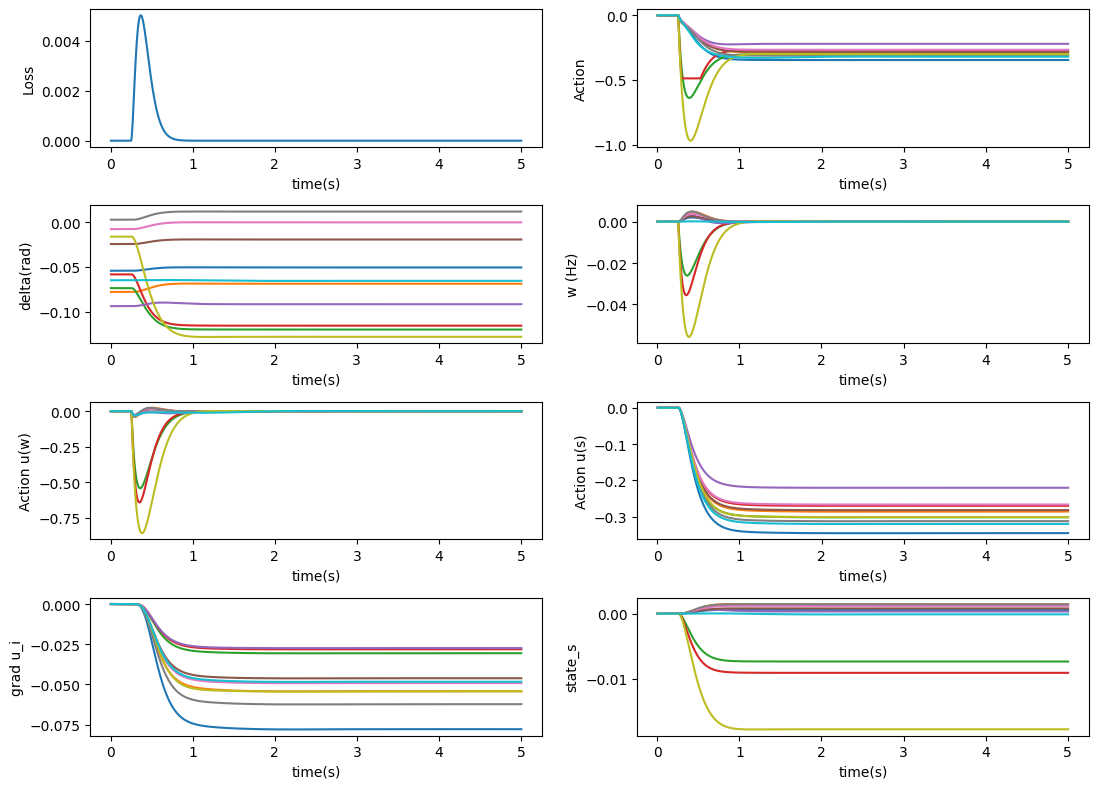

In [ ]:
# Compare the trajectory
Trajectory_RNN=[]
init_state=equilibrium_init
x=init_state.copy().astype(np.float32)
env.set_state(x)
Trajectory_RNN.append(x)
SimulationLength=1000
Record_u=[]
Record_up=[]
Record_ui=[]

Record_Loss=[]
Loss_RNN=0
Loss_RNN_discounted=0
Pm_init=Pm.copy()
Pm1=Pm_init.copy().astype(np.float32)
Pm2=(Pm_init.copy()).astype(np.float32)
gen_id=[2,3,8]
# gen_id = random.sample(range(dim_action), 3)
Pm2[0][gen_id]=-1

action_s = np.zeros((1,dim_action),dtype=np.float32)
record_grad_ui = []
Trajectory_s = []
Trajectory_s.append(np.squeeze(env.state_s))
for i in range(SimulationLength):
    if i<int(50) :
      Pm_change=Pm1.copy()
    if i>=int(50) :
      Pm_change=Pm2.copy()
    u, up, ui = Action_SCNN(x, action_s, model_WoCost_SCNN, env)

    action_s, next_x, r= env.step_PI_CommEdge_WoCost(up,ui,Pm_change)

    Loss_RNN_discounted+=r
    Loss_RNN+=r
    x=next_x
    Trajectory_RNN.append(x)
    Record_u.append(np.squeeze(u))
    Record_up.append(np.squeeze(up))
    Record_ui.append(np.squeeze(ui))
    Record_Loss.append(np.squeeze(r))
    record_grad_ui.append(np.squeeze(env.calc_grad_action(ui)[1]))
    Trajectory_s.append(np.squeeze(env.state_s))





Trajectory_RNN=np.squeeze(np.asarray(Trajectory_RNN))
Trajectory_s=np.squeeze(np.asarray(Trajectory_s))

fig = plt.figure(figsize=(11, 8), dpi=100)
TimeRecord=np.arange(1,SimulationLength+1)
TimeRecord=env.delta_t*TimeRecord
plt.subplot(4,2,1)

plt.plot(TimeRecord,Record_Loss)
plt.xlabel('time(s)')
plt.ylabel('Loss')

plt.subplot(4,2,2)

plt.plot(TimeRecord,Record_u)
plt.xlabel('time(s)')
plt.ylabel('Action')

plt.subplot(4,2,3)

TimeRecord=np.arange(1,SimulationLength+2)
TimeRecord=env.delta_t*TimeRecord
plt.plot(TimeRecord,Trajectory_RNN[:,0:action_units])
plt.xlabel('time(s)')
plt.ylabel('delta(rad)')


plt.subplot(4,2,4)
plt.plot(TimeRecord,Trajectory_RNN[:,action_units:action_units*2])
plt.xlabel('time(s)')
plt.ylabel('w (Hz)')


TimeRecord=np.arange(1,SimulationLength+1)
TimeRecord=env.delta_t*TimeRecord
plt.subplot(4,2,5)
plt.plot(TimeRecord,Record_up)
plt.xlabel('time(s)')
plt.ylabel('Action u(w)')


plt.subplot(4,2,6)

plt.plot(TimeRecord,Record_ui)
plt.xlabel('time(s)')
plt.ylabel('Action u(s)')
fig.tight_layout()

plt.subplot(4,2,7)
plt.plot(TimeRecord,record_grad_ui)
plt.xlabel('time(s)')
plt.ylabel('grad u_i')


plt.subplot(4,2,8)
TimeRecord=np.arange(1,SimulationLength+2)
TimeRecord=env.delta_t*TimeRecord
plt.plot(TimeRecord,Trajectory_s)
plt.xlabel('time(s)')
plt.ylabel('state_s')
fig.tight_layout()

## Neural-PI with Communication Constraints

In [ ]:
def softplus_beta(beta, x):
    return K.softplus(beta*x)/(beta)

@tf.function
def Action_ICNN_P3_CommHalf(obs, model, env):

    with tf.GradientTape() as tape:
        tape.watch(obs)
        subset_obs = K.dot(obs, Comm_set_matrix[0])
        z1 = softplus_beta(model.collect_beta[0], K.dot(subset_obs, model.collect_W_p1[0])+ model.collect_b_p1[0])
        z2 = softplus_beta(model.collect_beta[0], K.dot(subset_obs, model.collect_W_p2[0])+
                        K.dot(z1, model.collect_W_pz1[0])+
                        model.collect_b_p2[0])
        z3 = softplus_beta(model.collect_beta[0], K.dot(subset_obs, model.collect_W_p3[0])+
                        K.dot(z2, model.collect_W_pz2[0])+ model.collect_b_p3[0])

    # action_node_p = tf.squeeze(tape.batch_jacobian(z3, obs))

        for idx_subset in range(1,len(Comm_set)):
            # tape.watch(obs)
            # print('idx_subset', idx_subset)
            subset_obs = K.dot(obs, Comm_set_matrix[idx_subset])
            z1 = softplus_beta(model.collect_beta[idx_subset], K.dot(subset_obs, model.collect_W_p1[idx_subset])+
                            model.collect_b_p1[idx_subset])
            z2 = softplus_beta(model.collect_beta[idx_subset],K.dot(subset_obs, model.collect_W_p2[idx_subset])+
                            K.dot(z1, model.collect_W_pz1[idx_subset])+
                            model.collect_b_p2[idx_subset])
            z3 = z3+ softplus_beta(model.collect_beta[idx_subset],K.dot(subset_obs, model.collect_W_p3[idx_subset])+
                            K.dot(z2, model.collect_W_pz2[idx_subset])+ model.collect_b_p3[idx_subset])



    return tf.squeeze(tape.batch_jacobian(z3, obs))


@tf.function
def Action_ICNN_I3_CommHalf(obs, model, env):
    with tf.GradientTape() as tape:
        tape.watch(obs)
        subset_obs = K.dot(obs, Comm_set_matrix[0])
        z1 = softplus_beta(model.collect_beta[0], K.dot(subset_obs, model.collect_W_i1[0])+ model.collect_b_i1[0])
        z2 = softplus_beta(model.collect_beta[0], K.dot(subset_obs, model.collect_W_i2[0])+
                        K.dot(z1, model.collect_W_iz1[0])+
                        model.collect_b_i2[0])
        z3 = softplus_beta(model.collect_beta[0], K.dot(subset_obs, model.collect_W_i3[0])+
                        K.dot(z2, model.collect_W_iz2[0])+ model.collect_b_i3[0])
        for idx_subset in range(1,len(Comm_set)):

            subset_obs = K.dot(obs, Comm_set_matrix[idx_subset])
            z1 = softplus_beta(model.collect_beta[idx_subset],K.dot(subset_obs, model.collect_W_i1[idx_subset])+
                            model.collect_b_i1[idx_subset])
            z2 = softplus_beta(model.collect_beta[idx_subset],K.dot(subset_obs, model.collect_W_i2[idx_subset])+
                            K.dot(z1, model.collect_W_iz1[idx_subset])+
                            model.collect_b_i2[idx_subset])
            z3 = z3+ softplus_beta(model.collect_beta[idx_subset],K.dot(subset_obs, model.collect_W_i3[idx_subset])+
                            K.dot(z2, model.collect_W_iz2[idx_subset])+ model.collect_b_i3[idx_subset])

    return tf.squeeze(tape.batch_jacobian(z3, obs), axis=0)
    # return tape.batch_jacobian(z3, obs)


###########    add
def Action_ICNN3_CommHalf(state_x, state_s, model, env):
    action_nonconstrain0 = Action_ICNN_P3_CommHalf(state_x@env.select_w, model, env)\
                          -Action_ICNN_P3_CommHalf(model.obs_zeros, model, env)
    action_nonconstrain1 = Action_ICNN_I3_CommHalf(state_s,model, env)-Action_ICNN_I3_CommHalf(model.obs_zeros, model, env)
    action_nonconstrain =  action_nonconstrain0 + action_nonconstrain1
    # action = action_nonconstrain
    action=env.max_action-K.relu(env.max_action-action_nonconstrain)+K.relu(-env.max_action-action_nonconstrain)
    return action, action_nonconstrain0, action_nonconstrain1


tf.Tensor([[0.23131321]], shape=(1, 1), dtype=float32)


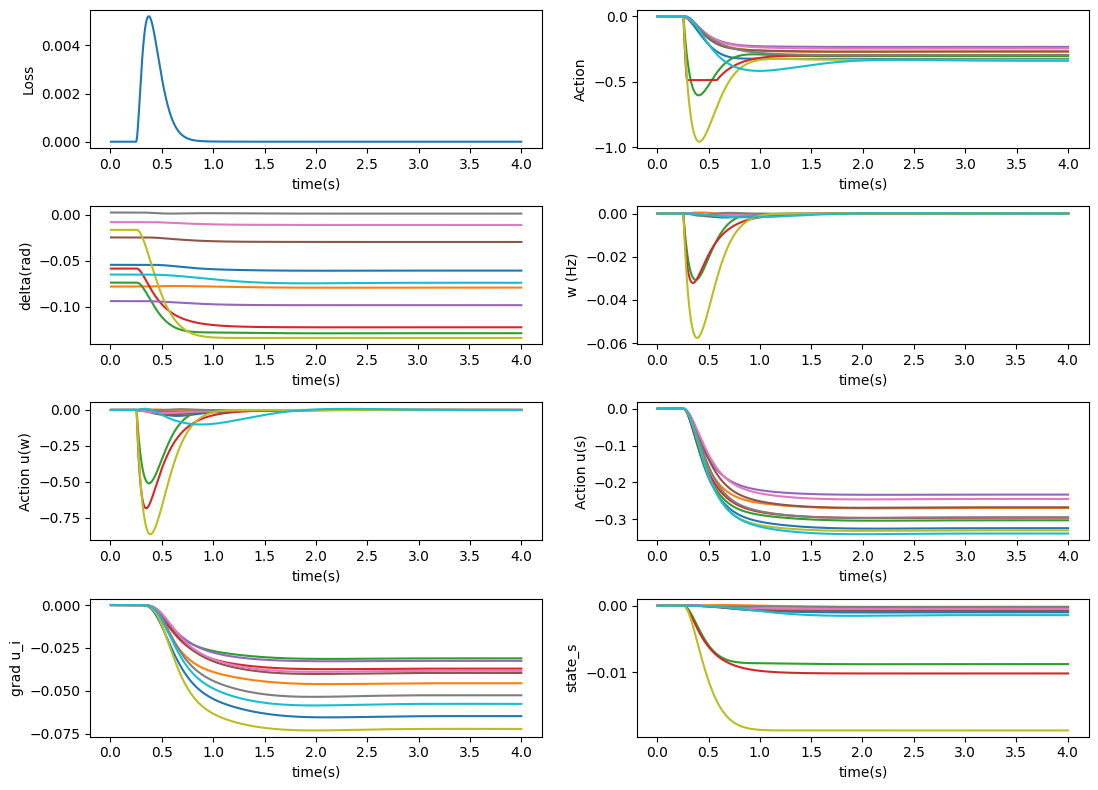

In [ ]:
# Compare the trajectory
Trajectory_RNN=[]

gen_id=[1,5]

init_state=equilibrium_init
linear_coff = np.ones((1,dim_action),dtype=np.float32)*0.5
linear_coff0 = linear_coff=np.array([[20.14369  , 28.201817 , 21.431381 , 50.06875  , 47.848213 ,
        40.610752 , 36.394817 , 15.173219 , 55.339428 , 13.4945965]], dtype=np.float32)*0.1


# init_state=env.reset()
x=init_state.copy().astype(np.float32)
env.set_state(x)
Trajectory_RNN.append(x)
SimulationLength=800
Record_u=[]
Record_up=[]
Record_ui=[]

Record_Loss=[]
Loss_RNN=0
Loss_RNN_discounted=0
Pm_init=Pm.copy()
Pm1=Pm_init.copy().astype(np.float32)
Pm2=(Pm_init.copy()).astype(np.float32)
gen_id=[2,3,8]
Pm2[0][gen_id]=-1
action_s = np.zeros((1,dim_action),dtype=np.float32)
record_grad_ui = []
Trajectory_s = []
Trajectory_s.append(np.squeeze(env.state_s))
for i in range(SimulationLength):
    if i<int(50) :
      Pm_change=Pm1.copy()
    if i>=int(50) :
      Pm_change=Pm2.copy()
    u, up, ui = Action_ICNN3_CommHalf(x, action_s, cell_WoCost_ICNN_CommHalf, env)

    action_s, next_x, r= env.step_PI_CommEdge_WoCost(up,ui,Pm_change)

    Loss_RNN_discounted+=r
    Loss_RNN+=r
    x=next_x
    Trajectory_RNN.append(x)
    Record_u.append(np.squeeze(u))
    Record_up.append(np.squeeze(up))
    Record_ui.append(np.squeeze(ui))
    Record_Loss.append(np.squeeze(r))
    record_grad_ui.append(np.squeeze(env.calc_grad_action(ui)[1]))
    Trajectory_s.append(np.squeeze(env.state_s))




print(Loss_RNN)

Trajectory_RNN=np.squeeze(np.asarray(Trajectory_RNN))
Trajectory_s=np.squeeze(np.asarray(Trajectory_s))
Record_u = np.squeeze(np.asarray(Record_u))
record_grad_ui = np.squeeze(np.asarray(record_grad_ui ))
fig = plt.figure(figsize=(11, 8), dpi=100)
TimeRecord=np.arange(1,SimulationLength+1)
TimeRecord=env.delta_t*TimeRecord
plt.subplot(4,2,1)

plt.plot(TimeRecord,Record_Loss)
plt.xlabel('time(s)')
plt.ylabel('Loss')

plt.subplot(4,2,2)

plt.plot(TimeRecord,Record_u)
plt.xlabel('time(s)')
plt.ylabel('Action')

plt.subplot(4,2,3)

TimeRecord=np.arange(1,SimulationLength+2)
TimeRecord=env.delta_t*TimeRecord
plt.plot(TimeRecord,Trajectory_RNN[:,0:action_units])
plt.xlabel('time(s)')
plt.ylabel('delta(rad)')


plt.subplot(4,2,4)
plt.plot(TimeRecord,Trajectory_RNN[:,action_units:action_units*2])
plt.xlabel('time(s)')
plt.ylabel('w (Hz)')


TimeRecord=np.arange(1,SimulationLength+1)
TimeRecord=env.delta_t*TimeRecord
plt.subplot(4,2,5)
plt.plot(TimeRecord,Record_up)
plt.xlabel('time(s)')
plt.ylabel('Action u(w)')


plt.subplot(4,2,6)

plt.plot(TimeRecord,Record_ui)
plt.xlabel('time(s)')
plt.ylabel('Action u(s)')
fig.tight_layout()

plt.subplot(4,2,7)
plt.plot(TimeRecord,record_grad_ui)
plt.xlabel('time(s)')
plt.ylabel('grad u_i')


plt.subplot(4,2,8)
TimeRecord=np.arange(1,SimulationLength+2)
TimeRecord=env.delta_t*TimeRecord
plt.plot(TimeRecord,Trajectory_s)
plt.xlabel('time(s)')
plt.ylabel('state_s')
fig.tight_layout()

## Neural-PI Decentralized

In [ ]:
@tf.function
def Action_ICNN_P2_Decentralized(obs, model, env):

    with tf.GradientTape() as tape:
        tape.watch(obs)
        subset_obs = K.dot(obs, Comm_set_Decentralized_matrix[0])
        z1 = K.softplus(K.dot(subset_obs, cell_WoCost_ICNN_Decentralized.collect_W_p1[0])+ cell_WoCost_ICNN_Decentralized.collect_b_p1[0])
        # z2 = K.softplus(K.dot(obs, cell_WoCost_ICNN_Decentralized.W_p2)+K.dot(z1, cell_WoCost_ICNN_Decentralized.W_pz1)+ cell_WoCost_ICNN_Decentralized.b_p2)
        z3 = K.softplus(K.dot(subset_obs, cell_WoCost_ICNN_Decentralized.collect_W_p3[0])+
                        K.dot(z1, cell_WoCost_ICNN_Decentralized.collect_W_pz2[0])+ cell_WoCost_ICNN_Decentralized.collect_b_p3[0])

    # action_node_p = tf.squeeze(tape.batch_jacobian(z3, obs))

        for idx_subset in range(1,len(Comm_set_Decentralized)):
            # tape.watch(obs)
            # print('idx_subset', idx_subset)
            subset_obs = K.dot(obs, Comm_set_Decentralized_matrix[idx_subset])
            z1 = K.softplus(K.dot(subset_obs, cell_WoCost_ICNN_Decentralized.collect_W_p1[idx_subset])+
                            cell_WoCost_ICNN_Decentralized.collect_b_p1[idx_subset])
            # z2 = K.softplus(K.dot(obs, cell_WoCost_ICNN_Decentralized.W_p2)+K.dot(z1, cell_WoCost_ICNN_Decentralized.W_pz1)+ cell_WoCost_ICNN_Decentralized.b_p2)
            z3 = z3+ K.softplus(K.dot(subset_obs, cell_WoCost_ICNN_Decentralized.collect_W_p3[idx_subset])+
                            K.dot(z1, cell_WoCost_ICNN_Decentralized.collect_W_pz2[idx_subset])+ cell_WoCost_ICNN_Decentralized.collect_b_p3[idx_subset])



    return tf.squeeze(tape.batch_jacobian(z3, obs))


@tf.function
def Action_ICNN_I2_Decentralized(obs, model, env):
    with tf.GradientTape() as tape:
        tape.watch(obs)
        subset_obs = K.dot(obs, Comm_set_Decentralized_matrix[0])
        z1 = K.softplus(K.dot(subset_obs, cell_WoCost_ICNN_Decentralized.collect_W_i1[0])+ cell_WoCost_ICNN_Decentralized.collect_b_i1[0])
        z3 = K.softplus(K.dot(subset_obs, cell_WoCost_ICNN_Decentralized.collect_W_i3[0])+
                        K.dot(z1, cell_WoCost_ICNN_Decentralized.collect_W_iz2[0])+ cell_WoCost_ICNN_Decentralized.collect_b_i3[0])
        for idx_subset in range(1,len(Comm_set_Decentralized)):

            subset_obs = K.dot(obs, Comm_set_Decentralized_matrix[idx_subset])
            z1 = K.softplus(K.dot(subset_obs, cell_WoCost_ICNN_Decentralized.collect_W_i1[idx_subset])+
                            cell_WoCost_ICNN_Decentralized.collect_b_i1[idx_subset])
            z3 = z3+ K.softplus(K.dot(subset_obs, cell_WoCost_ICNN_Decentralized.collect_W_i3[idx_subset])+
                            K.dot(z1, cell_WoCost_ICNN_Decentralized.collect_W_iz2[idx_subset])+ cell_WoCost_ICNN_Decentralized.collect_b_i3[idx_subset])

    return tf.squeeze(tape.batch_jacobian(z3, obs), axis=0)
    # return tape.batch_jacobian(z3, obs)


###########    add
def Action_ICNN2_Decentralized(state_x, state_s, model, env):
    action_nonconstrain0 = Action_ICNN_P2_Decentralized(state_x@env.select_w, model, env)\
                          -Action_ICNN_P2_Decentralized(cell_WoCost_ICNN.obs_zeros, model, env)
    action_nonconstrain1 = Action_ICNN_I2_Decentralized(state_s,model, env)-Action_ICNN_I2_Decentralized(cell_WoCost_ICNN.obs_zeros, model, env)
    action_nonconstrain =  action_nonconstrain0 + action_nonconstrain1
    # action = action_nonconstrain
    action=env.max_action-K.relu(env.max_action-action_nonconstrain)+K.relu(-env.max_action-action_nonconstrain)
    return action, action_nonconstrain0, action_nonconstrain1


tf.Tensor([[0.1973619]], shape=(1, 1), dtype=float32)


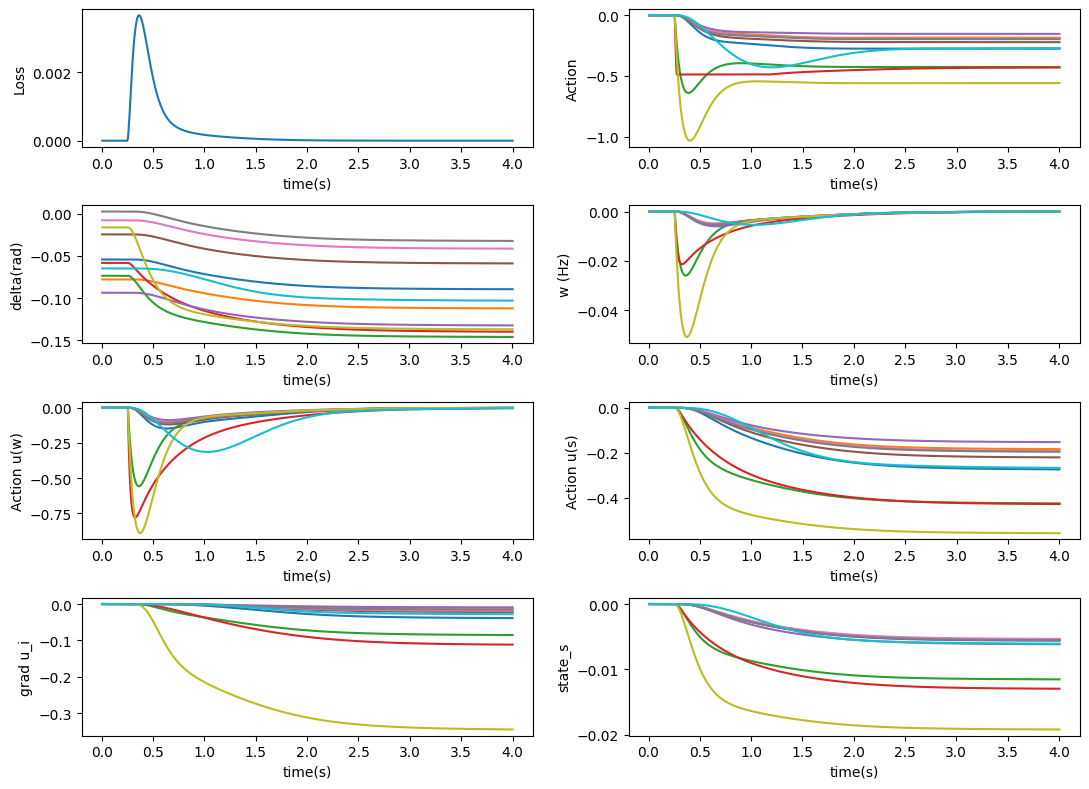

In [ ]:
# Compare the trajectory
Trajectory_RNN=[]

gen_id=[1,5]

init_state=equilibrium_init
linear_coff = np.ones((1,dim_action),dtype=np.float32)*0.5
linear_coff0 = linear_coff=np.array([[20.14369  , 28.201817 , 21.431381 , 50.06875  , 47.848213 ,
        40.610752 , 36.394817 , 15.173219 , 55.339428 , 13.4945965]], dtype=np.float32)*0.1


x=init_state.copy().astype(np.float32)
env.set_state(x)
Trajectory_RNN.append(x)
SimulationLength=800
Record_u=[]
Record_up=[]
Record_ui=[]

Record_Loss=[]
Loss_RNN=0
Loss_RNN_discounted=0
Pm_init=Pm.copy()
Pm1=Pm_init.copy().astype(np.float32)
Pm2=(Pm_init.copy()).astype(np.float32)
gen_id=[2,3,8]
# gen_id = random.sample(range(dim_action), 3)
Pm2[0][gen_id]=-1

action_s = np.zeros((1,dim_action),dtype=np.float32)
record_grad_ui = []
Trajectory_s = []
Trajectory_s.append(np.squeeze(env.state_s))
for i in range(SimulationLength):

    if i<int(50) :
      Pm_change=Pm1.copy()
    if i>=int(50) :
      Pm_change=Pm2.copy()

    u, up, ui = Action_ICNN2_Decentralized(x, action_s, cell_WoCost_ICNN_Decentralized, env)


    action_s, next_x, r= env.step_PI_CommEdge_WoCost(up,ui,Pm_change)

    Loss_RNN_discounted+=r
    Loss_RNN+=r
    x=next_x
    Trajectory_RNN.append(x)
    Record_u.append(np.squeeze(u))
    Record_up.append(np.squeeze(up))
    Record_ui.append(np.squeeze(ui))
    Record_Loss.append(np.squeeze(r))
    record_grad_ui.append(np.squeeze(env.calc_grad_action(ui)[1]))
    Trajectory_s.append(np.squeeze(env.state_s))




print(Loss_RNN)

Trajectory_RNN=np.squeeze(np.asarray(Trajectory_RNN))
Trajectory_s=np.squeeze(np.asarray(Trajectory_s))
Record_u = np.squeeze(np.asarray(Record_u))
record_grad_ui = np.squeeze(np.asarray(record_grad_ui ))
fig = plt.figure(figsize=(11, 8), dpi=100)
TimeRecord=np.arange(1,SimulationLength+1)
TimeRecord=env.delta_t*TimeRecord
plt.subplot(4,2,1)

plt.plot(TimeRecord,Record_Loss)
plt.xlabel('time(s)')
plt.ylabel('Loss')

plt.subplot(4,2,2)

plt.plot(TimeRecord,Record_u)
plt.xlabel('time(s)')
plt.ylabel('Action')

plt.subplot(4,2,3)

TimeRecord=np.arange(1,SimulationLength+2)
TimeRecord=env.delta_t*TimeRecord
plt.plot(TimeRecord,Trajectory_RNN[:,0:action_units])
plt.xlabel('time(s)')
plt.ylabel('delta(rad)')


plt.subplot(4,2,4)
plt.plot(TimeRecord,Trajectory_RNN[:,action_units:action_units*2])
plt.xlabel('time(s)')
plt.ylabel('w (Hz)')


TimeRecord=np.arange(1,SimulationLength+1)
TimeRecord=env.delta_t*TimeRecord
plt.subplot(4,2,5)
plt.plot(TimeRecord,Record_up)
plt.xlabel('time(s)')
plt.ylabel('Action u(w)')


plt.subplot(4,2,6)

plt.plot(TimeRecord,Record_ui)
plt.xlabel('time(s)')
plt.ylabel('Action u(s)')
fig.tight_layout()

plt.subplot(4,2,7)
plt.plot(TimeRecord,record_grad_ui)
plt.xlabel('time(s)')
plt.ylabel('grad u_i')


plt.subplot(4,2,8)
TimeRecord=np.arange(1,SimulationLength+2)
TimeRecord=env.delta_t*TimeRecord
plt.plot(TimeRecord,Trajectory_s)
plt.xlabel('time(s)')
plt.ylabel('state_s')
fig.tight_layout()

## Linear-PI

In [ ]:
@tf.function
def Action_Linear_P(obs, model, env):

    z1 = K.dot(obs,  model.variables[0])
    return z1



@tf.function
def Action_Linear_I(obs, model, env):

    z1 = K.dot(obs,  model.variables[1])
    return z1


###########    add
def Action_Linear(state_x, state_s, model, env):
    action_nonconstrain0 = Action_Linear_P(state_x@env.select_w, model, env)
    action_nonconstrain1 = Action_Linear_I(state_s,model, env)
    action_nonconstrain =  action_nonconstrain0 + action_nonconstrain1
    # action = action_nonconstrain
    action=env.max_action-K.relu(env.max_action-action_nonconstrain)+K.relu(-env.max_action-action_nonconstrain)
    return action, action_nonconstrain0, action_nonconstrain1


tf.Tensor([[0.85058534]], shape=(1, 1), dtype=float32)


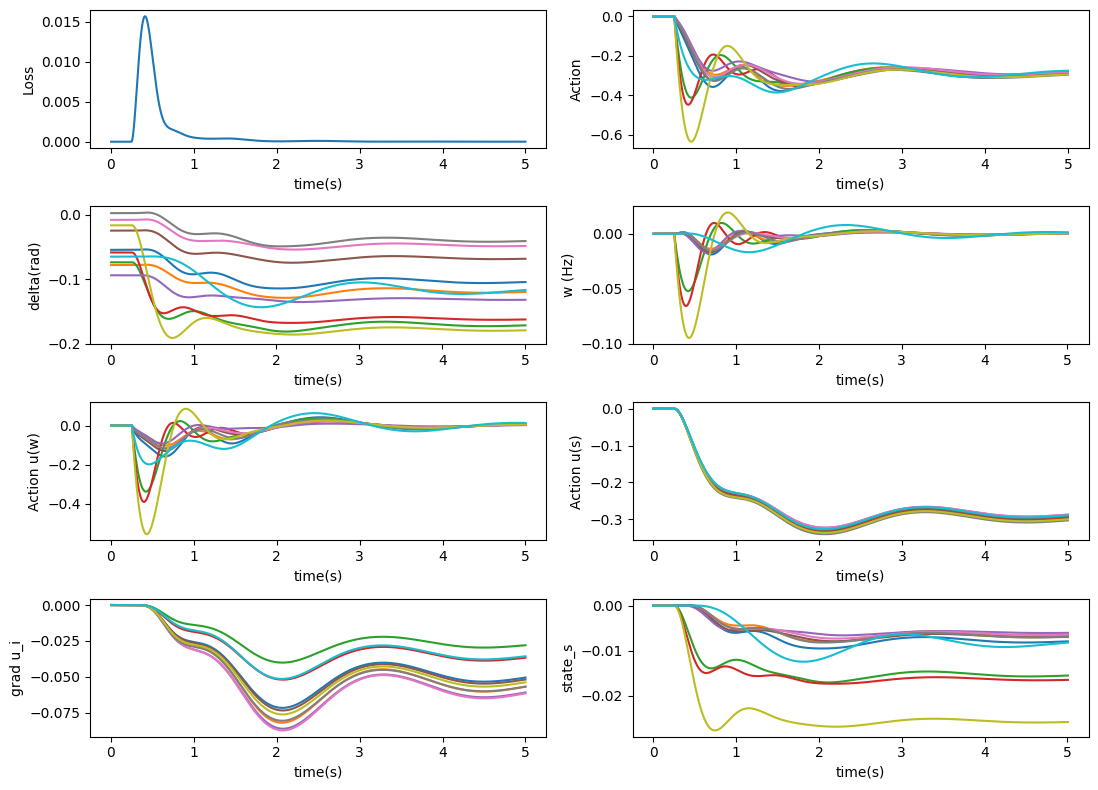

In [ ]:
# Compare the trajectory
Trajectory_RNN=[]


init_state=equilibrium_init


# init_state=env.reset()
x=init_state.copy().astype(np.float32)
env.set_state(x)
Trajectory_RNN.append(x)
SimulationLength=1000
Record_u=[]
Record_up=[]
Record_ui=[]

Record_Loss=[]
Loss_RNN=0
Loss_RNN_discounted=0
Pm_init=Pm.copy()
Pm1=Pm_init.copy().astype(np.float32)
Pm2=(Pm_init.copy()).astype(np.float32)
gen_id=[2,3,8]
# gen_id = random.sample(range(dim_action), 3)
Pm2[0][gen_id]=-1
# Pm2=(Pm_init.copy()).astype(np.float32)*0

# Pm_init[0][gen_id]*2# idx_load_increase=2
action_s = np.zeros((1,dim_action),dtype=np.float32)
record_grad_ui = []
Trajectory_s = []
Trajectory_s.append(np.squeeze(env.state_s))
for i in range(SimulationLength):
    if i<int(50) :
      Pm_change=Pm1.copy()
    if i>=int(50) :
      Pm_change=Pm2.copy()
    u, up, ui = Action_Linear(x, action_s, model_WoCost_Linear, env)


    action_s, next_x, r= env.step_PI_CommEdge_WoCost(up,ui,Pm_change)

    Loss_RNN_discounted+=r
    Loss_RNN+=r
    x=next_x
    Trajectory_RNN.append(x)
    Record_u.append(np.squeeze(u))
    Record_up.append(np.squeeze(up))
    Record_ui.append(np.squeeze(ui))
    Record_Loss.append(np.squeeze(r))
    record_grad_ui.append(np.squeeze(env.calc_grad_action(ui)[1]))
    Trajectory_s.append(np.squeeze(env.state_s))




print(Loss_RNN)

Trajectory_RNN=np.squeeze(np.asarray(Trajectory_RNN))
Trajectory_s=np.squeeze(np.asarray(Trajectory_s))

fig = plt.figure(figsize=(11, 8), dpi=100)
TimeRecord=np.arange(1,SimulationLength+1)
TimeRecord=env.delta_t*TimeRecord
plt.subplot(4,2,1)

plt.plot(TimeRecord,Record_Loss)
plt.xlabel('time(s)')
plt.ylabel('Loss')

plt.subplot(4,2,2)

plt.plot(TimeRecord,Record_u)
plt.xlabel('time(s)')
plt.ylabel('Action')

plt.subplot(4,2,3)

TimeRecord=np.arange(1,SimulationLength+2)
TimeRecord=env.delta_t*TimeRecord
plt.plot(TimeRecord,Trajectory_RNN[:,0:action_units])
plt.xlabel('time(s)')
plt.ylabel('delta(rad)')


plt.subplot(4,2,4)
plt.plot(TimeRecord,Trajectory_RNN[:,action_units:action_units*2])
plt.xlabel('time(s)')
plt.ylabel('w (Hz)')


TimeRecord=np.arange(1,SimulationLength+1)
TimeRecord=env.delta_t*TimeRecord
plt.subplot(4,2,5)
plt.plot(TimeRecord,Record_up)
plt.xlabel('time(s)')
plt.ylabel('Action u(w)')


plt.subplot(4,2,6)

plt.plot(TimeRecord,Record_ui)
plt.xlabel('time(s)')
plt.ylabel('Action u(s)')
fig.tight_layout()

plt.subplot(4,2,7)
plt.plot(TimeRecord,record_grad_ui)
plt.xlabel('time(s)')
plt.ylabel('grad u_i')


plt.subplot(4,2,8)
TimeRecord=np.arange(1,SimulationLength+2)
TimeRecord=env.delta_t*TimeRecord
plt.plot(TimeRecord,Trajectory_s)
plt.xlabel('time(s)')
plt.ylabel('state_s')
fig.tight_layout()

## DenseNN-PI

In [ ]:
@tf.function
def Action_NNMatrix_P3(obs, model, env):
    z1 = K.softplus(K.dot(obs, model.variables[0])+ model.variables[1])
    z2 = K.softplus(K.dot(obs, model.variables[2])+K.dot(z1, model.variables[3])+ model.variables[4])
    z3 = K.dot(obs, model.variables[5])+K.dot(z2, model.variables[6])+ model.variables[7]

    return z3


@tf.function
def Action_NNMatrix_I3(obs, model, env):

    z1 = K.softplus(K.dot(obs, model.variables[8])+ model.variables[9])
    z2 = K.softplus(K.dot(obs, model.variables[10])+K.dot(z1, model.variables[11])+ model.variables[12])
    z3 = K.dot(obs, model.variables[13])+K.dot(z2, model.variables[14])+ model.variables[15]

    return z3
    # tf.squeeze(tape.batch_jacobian(z3, obs), axis=0)

###########    add
def Action_NNMatrix3(state_x, state_s, model, env):
    action_nonconstrain0 = Action_NNMatrix_P3(state_x@env.select_w, model, env)
    action_nonconstrain1 = Action_NNMatrix_I3(state_s,model, env)
    action_nonconstrain =  action_nonconstrain0 + action_nonconstrain1
    # action = action_nonconstrain
    action=env.max_action-K.relu(env.max_action-action_nonconstrain)+K.relu(-env.max_action-action_nonconstrain)
    return action, action_nonconstrain0, action_nonconstrain1


tf.Tensor([[1.9697452]], shape=(1, 1), dtype=float32)


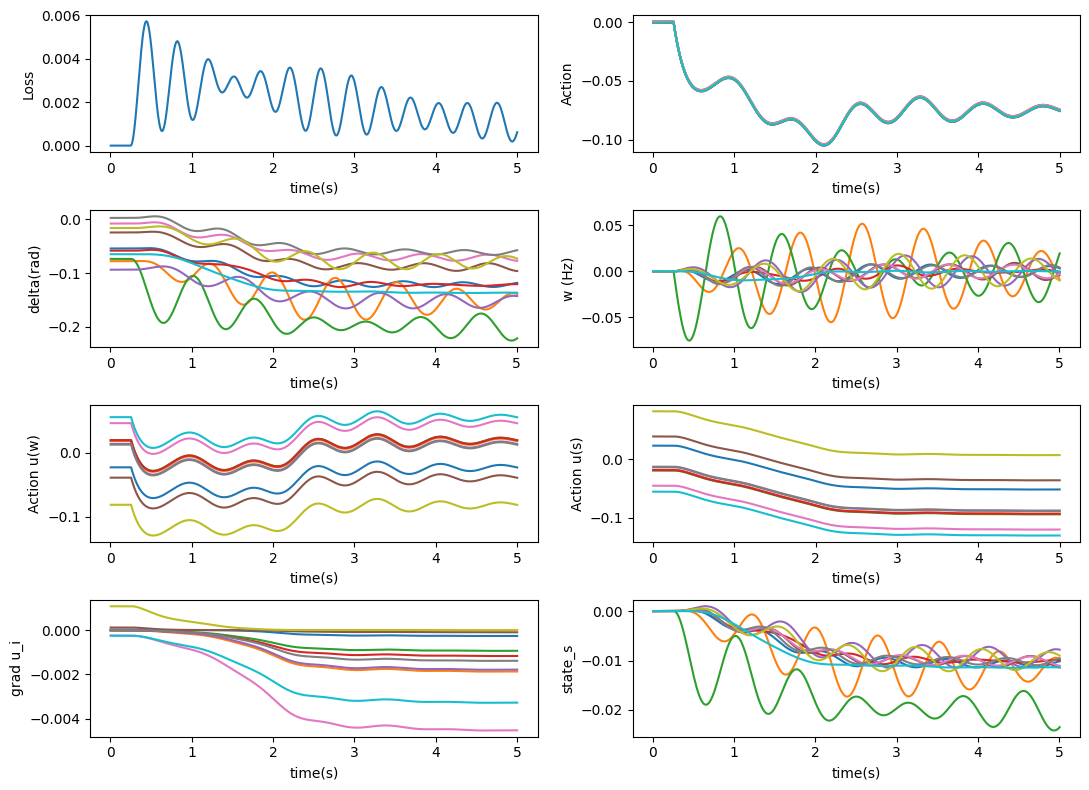

In [ ]:
# Compare the trajectory
Trajectory_RNN=[]


init_state=equilibrium_init


# init_state=env.reset()
x=init_state.copy().astype(np.float32)
env.set_state(x)
Trajectory_RNN.append(x)
SimulationLength=1000
Record_u=[]
Record_up=[]
Record_ui=[]

Record_Loss=[]
Loss_RNN=0
Loss_RNN_discounted=0
Pm_init=Pm.copy()
Pm1=Pm_init.copy().astype(np.float32)
Pm2=(Pm_init.copy()).astype(np.float32)
# gen_id=[2,3,8]
gen_id=[2]

# gen_id = random.sample(range(dim_action), 3)
Pm2[0][gen_id]=-1

action_s = np.zeros((1,dim_action),dtype=np.float32)
record_grad_ui = []
Trajectory_s = []
Trajectory_s.append(np.squeeze(env.state_s))
for i in range(SimulationLength):

    if i<int(50) :
      Pm_change=Pm1.copy()
    if i>=int(50) :
      Pm_change=Pm2.copy()

    u, up, ui = Action_NNMatrix3(x, action_s, model_WoCost_NNMatrix, env)

    action_s, next_x, r= env.step_PI_CommEdge_WoCost(up,ui,Pm_change)

    Loss_RNN_discounted+=r
    Loss_RNN+=r
    x=next_x
    Trajectory_RNN.append(x)
    Record_u.append(np.squeeze(u))
    Record_up.append(np.squeeze(up))
    Record_ui.append(np.squeeze(ui))
    Record_Loss.append(np.squeeze(r))
    record_grad_ui.append(np.squeeze(env.calc_grad_action(ui)[1]))
    Trajectory_s.append(np.squeeze(env.state_s))




print(Loss_RNN)

Trajectory_RNN=np.squeeze(np.asarray(Trajectory_RNN))
Trajectory_s=np.squeeze(np.asarray(Trajectory_s))

fig = plt.figure(figsize=(11, 8), dpi=100)
TimeRecord=np.arange(1,SimulationLength+1)
TimeRecord=env.delta_t*TimeRecord
plt.subplot(4,2,1)

plt.plot(TimeRecord,Record_Loss)
plt.xlabel('time(s)')
plt.ylabel('Loss')

plt.subplot(4,2,2)

plt.plot(TimeRecord,Record_u)
plt.xlabel('time(s)')
plt.ylabel('Action')

plt.subplot(4,2,3)

TimeRecord=np.arange(1,SimulationLength+2)
TimeRecord=env.delta_t*TimeRecord
plt.plot(TimeRecord,Trajectory_RNN[:,0:action_units])
plt.xlabel('time(s)')
plt.ylabel('delta(rad)')


plt.subplot(4,2,4)
plt.plot(TimeRecord,Trajectory_RNN[:,action_units:action_units*2])
plt.xlabel('time(s)')
plt.ylabel('w (Hz)')


TimeRecord=np.arange(1,SimulationLength+1)
TimeRecord=env.delta_t*TimeRecord
plt.subplot(4,2,5)
plt.plot(TimeRecord,Record_up)
plt.xlabel('time(s)')
plt.ylabel('Action u(w)')


plt.subplot(4,2,6)

plt.plot(TimeRecord,Record_ui)
plt.xlabel('time(s)')
plt.ylabel('Action u(s)')
fig.tight_layout()

plt.subplot(4,2,7)
plt.plot(TimeRecord,record_grad_ui)
plt.xlabel('time(s)')
plt.ylabel('grad u_i')


plt.subplot(4,2,8)
TimeRecord=np.arange(1,SimulationLength+2)
TimeRecord=env.delta_t*TimeRecord
plt.plot(TimeRecord,Trajectory_s)
plt.xlabel('time(s)')
plt.ylabel('state_s')
fig.tight_layout()